In [1]:
import matplotlib
preamble = r'''\usepackage{fontspec}
\setmainfont{Linux Libertine O}'''

fontsize = 17
ticklen = 5
params = {
    'font.size': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'axes.labelsize': fontsize,
    'legend.fontsize': fontsize,
    'text.usetex': True,
    'pgf.rcfonts': False,
    'pgf.texsystem': 'xelatex',
    'pgf.preamble': preamble,
    'xtick.major.size' : ticklen,
    'ytick.major.size' : ticklen,
    'xtick.minor.size' : ticklen/2,
    'ytick.minor.size' : ticklen/2
}
matplotlib.rcParams.update(params)

from mpl_toolkits.axes_grid1 import make_axes_locatable

import astropy.constants as const
from astropy.table import Table, Column
from astropy.io import fits
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings("ignore")

import urllib.request

import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.colors

import pandas as pd

# from corner import corner
import corner

from tqdm import tqdm
# from tqdm.notebook import tqdm

import sys
sys.path.insert(1, '../')

from SPCA import Decorrelation_helper as dh

In [2]:
mainpath   = '/home/taylor/Documents/Research/spitzer/MEGA/'
rootpath = mainpath

planets = np.array(['HD189733b', 'WASP-43b', 'Qatar-1b', 'HD209458b', 'CoRoT-2b',
                    'WASP-14b', 'WASP-19b', 'HAT-P-7b', 'WASP-18b', 'KELT-1b',
                    'KELT-16b', 'WASP-103b', 'MASCARA-1b', 'WASP-12b', 'WASP-12b_old',
                    'WASP-33b', 'KELT-9b'])
channels = ['ch2' for planet in planets]

In [3]:
import numpy                  # numpy.scipy.org/
import scipy.odr              # docs.scipy.org/doc/scipy/reference/odr.html

#################################################################
#### Define functions that may be referenced in the User
####     definitions that immediately follow
#################################################################
# Define some uncertainty distribution functions for smearing data
def gaussian_distribution(x,dx):
    from numpy.random import normal
    return normal(x,dx)
def uniform_distribution(x,dx):
    from numpy.random import uniform
    return uniform(x-dx, x+dx)
def t_distribution(x,dx,nu=1):
    # Student's t distribution with nu degrees of freedom
    #   The default (nu=1) is Cauchy/Lorentzian
    from numpy.random import standard_t
    return x+dx*standard_t(nu,len(dx))

## Define some possible functions to be fitted
#    You may, of course, define your own.
#  The arguments for these functions are (x,*p), e.g. instead of (p,x),
#    to be consistent with what is used for scipy.optimize.curve_fit
def linear(x,*p) :
    # A linear function with:
    a      = p[0]    #   zero
    b      = p[1]    #   slope
    return a + b * x
def slope(x, *p) :
    b      = p[0]    #   slope
    return b * x

In [4]:
def recompute_Tb(fp_MCMC, rp_MCMC, A_MCMC, planet, channel, rootpath):
    if channel=='ch1':
        wav=3.6e-6
    else:
        wav=4.5e-6
    
    nIters = 10000
    fp_MCMC = np.random.normal(fp_MCMC[0], np.mean(fp_MCMC[1:]), nIters)
    rp_MCMC = np.random.normal(rp_MCMC[0], np.mean(rp_MCMC[1:]), nIters)
    A_MCMC = np.random.normal(A_MCMC[0], np.mean(A_MCMC[1:]), nIters)
    
    tstar_b = compute_Tstarb(planet, channel, rootpath)
    tstar_b = np.random.normal(tstar_b[0], tstar_b[1], nIters)
    
    tday = const.h.value*const.c.value/(const.k_B.value*wav)*(np.log(1+(np.exp(const.h.value*const.c.value/(const.k_B.value*wav*tstar_b))-1)/(fp_MCMC/rp_MCMC**2)))**-1
    tnight = const.h.value*const.c.value/(const.k_B.value*wav)*(np.log(1+(np.exp(const.h.value*const.c.value/(const.k_B.value*wav*tstar_b))-1)/(fp_MCMC*(1-2*A_MCMC)/rp_MCMC**2)))**-1
    
    return np.array([np.nanmedian(tday), np.nanpercentile(tday, 84)-np.nanmedian(tday), np.nanmedian(tday)-np.nanpercentile(tday, 16),
            np.nanmedian(tnight), np.nanpercentile(tnight, 84)-np.nanmedian(tnight), np.nanmedian(tnight)-np.nanpercentile(tnight, 16)])

def compute_Tstarb(planet, channel, rootpath):
    if os.path.exists('../masterfile.ecsv'):
        data = Table.to_pandas(Table.read('../masterfile.ecsv'))
    else:
        print('ERROR: No previously downloaded Exoplanet Archive data - try again when you are connected to the internet.')
        print(FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), '../masterfile.ecsv'))
        exit()

    names = np.array(data['pl_hostname'])+np.array(data['pl_letter'])
    names = np.array([name.replace(' ','').replace('-', '').replace('_','') for name in names])

    nameIndex = np.where(names==planet.replace(' ','').replace('-', '').split('_')[0])[0][0]
    
    if np.isfinite(data['pl_ratdor'][nameIndex]):
        a = data['pl_ratdor'][nameIndex]
        a_err = np.nanmean([data['pl_ratdorerr1'][nameIndex],
                                -data['pl_ratdorerr2'][nameIndex]])
    else:
        a = data['pl_orbsmax'][nameIndex]*const.au.value/data['st_rad'][nameIndex]/const.R_sun.value
        a_err = np.sqrt(
            (np.nanmean([data['pl_orbsmaxerr1'][nameIndex], -data['pl_orbsmaxerr2'][nameIndex]])*const.au.value
             /data['st_rad'][nameIndex]/const.R_sun.value)**2
            + (data['pl_orbsmax'][nameIndex]*const.au.value
               /data['st_rad'][nameIndex]**2/const.R_sun.value
               *np.nanmean([data['st_raderr1'][nameIndex], -data['st_raderr2'][nameIndex]]))**2
        )
    
    Tstar = data['st_teff'][nameIndex]
    Tstar_err = np.nanmean([data['st_tefferr1'][nameIndex],
                                -data['st_tefferr2'][nameIndex]])

    if planet=='KELT-1b':
        Tstar, Tstar_err = (6518, 50)
    
    # Get the phoenix file ready to compute the stellar brightness temperature
    teffStr = Tstar
    if teffStr <= 7000:
        teffStr = teffStr - (teffStr%100) + np.rint((teffStr%100)/100)*100
    elif teffStr > 7000:
        teffStr = teffStr - (teffStr%200) + np.rint((teffStr%200)/200)*200
    elif teffStr > 12000:
        teffStr = 12000
    teffStr = str(int(teffStr)).zfill(5)
    
    logg = data['st_logg'][nameIndex]
    if np.isnan(logg):
        logg = 4.5
    logg = logg - (logg%0.5) + np.rint((logg%0.5)*2)/2.
    logg = -logg
    feh = data['st_metfe'][nameIndex]
    if np.isnan(feh):
        feh = 0.
    feh = (feh - (feh%0.5) + np.rint((feh%0.5)*2)/2.)
    if feh<-2.:
        feh = (feh - (feh%1) + np.rint((feh%1)))
    
    webfolder = 'ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS/'
    phoenixPath = rootpath+planet+'/phoenix/'
    phoenixWavFile = phoenixPath+'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits'
    if not os.path.exists(phoenixPath):
        print('Downloading relevant PHOENIX wavelengths file...')
        os.mkdir(phoenixPath)
        try:
            _ = urllib.request.urlretrieve(webfolder+'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits', phoenixWavFile)
        except:
            print('ERROR: No previously downloaded PHOENIX data - try again when you are connected to the internet.')
            exit()
        print('Done download.')

    webfolder += 'PHOENIX-ACES-AGSS-COND-2011/Z'+("{0:+.01f}".format(feh) if feh!=0 else '-0.0')+'/'

    webfile = ('lte'+teffStr
             +("{0:+.02f}".format(logg) if logg!=0 else '-0.00')
             +("{0:+.01f}".format(feh) if feh!=0 else '-0.0')
             +'.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')

    phoenixSpectraFile = phoenixPath+webfile

    if not os.path.exists(phoenixSpectraFile):
        print('Downloading relevant PHOENIX spectra...')
        try:
            _ = urllib.request.urlretrieve(webfolder+webfile, phoenixSpectraFile)
        except:
            print('ERROR: No previously downloaded PHOENIX data - try again when you are connected to the internet.')
            exit()
        print('Done download.')
    
    f = fits.open(phoenixSpectraFile)
    fStar = f[0].data*1e-1 # 'erg/s/cm^2/cm' to kg/s^3
    f.close()
    f = fits.open(phoenixWavFile)
    wavStar = f[0].data*1e-4 # angstrom to micron
    f.close()

    def planck(wav, T):
        intensity = (2.0*const.h.value*const.c.value**2) / ((wav**5) * (np.exp(const.h.value*const.c.value/(wav*const.k_B.value*T)) - 1.0))
        return intensity
    def fluxDiff(temp, fStarSummed, wavs):
        #factor of pi likely needed to account for emitting area (pi*rstar^2 where rstar=1)
        return (np.sum(planck(wavs, temp)*np.pi)-fStarSummed)**2
    temps = np.linspace(3000, 11000, 801, endpoint=True)
    if channel == 'ch1':
        incides = np.where(np.logical_and(wavStar < 4., wavStar > 3.))[0]
    else:
        incides = np.where(np.logical_and(wavStar < 5., wavStar > 4.))[0]
    diffs = [fluxDiff(temp, np.sum(fStar[incides]), wavStar[incides]*1e-6) for temp in temps]
    tstar_b = temps[np.argmin(diffs)]
    
    return tstar_b, Tstar_err
    
def compute_T0(planet):
    if os.path.exists('../masterfile.ecsv'):
        data = Table.to_pandas(Table.read('../masterfile.ecsv'))
    else:
        print('ERROR: No previously downloaded Exoplanet Archive data - try again when you are connected to the internet.')
        print(FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), '../masterfile.ecsv'))
        exit()

    names = np.array(data['pl_hostname'])+np.array(data['pl_letter'])
    names = np.array([name.replace(' ','').replace('-', '').replace('_','') for name in names])

    nameIndex = np.where(names==planet.replace(' ','').replace('-', '').split('_')[0])[0][0]
    
    if np.isfinite(data['pl_ratdor'][nameIndex]):
        a = data['pl_ratdor'][nameIndex]
        a_err = np.mean([data['pl_ratdorerr1'][nameIndex],
                                -data['pl_ratdorerr2'][nameIndex]])
    else:
        a = data['pl_orbsmax'][nameIndex]*const.au.value/data['st_rad'][nameIndex]/const.R_sun.value
        a_err = np.sqrt(
            (np.mean([data['pl_orbsmaxerr1'][nameIndex], -data['pl_orbsmaxerr2'][nameIndex]])*const.au.value
             /data['st_rad'][nameIndex]/const.R_sun.value)**2
            + (data['pl_orbsmax'][nameIndex]*const.au.value
               /data['st_rad'][nameIndex]**2/const.R_sun.value
               *np.mean([data['st_raderr1'][nameIndex], -data['st_raderr2'][nameIndex]]))**2
        )
    
    Tstar = data['st_teff'][nameIndex]
    Tstar_err = np.mean([data['st_tefferr1'][nameIndex],
                                -data['st_tefferr2'][nameIndex]])

    if planet=='KELT-1b':
        Tstar, Tstar_err = (6518, 50)
    
    nIters = 10000
    Tstar = np.random.normal(Tstar, Tstar_err, nIters)
    a = np.random.normal(a, a_err, nIters)
    
    T0 = Tstar*np.sqrt(1/a)
    return np.array([np.median(T0), np.std(T0)])

In [5]:
import george
from george import kernels
from scipy.interpolate import interp1d
import scipy.constants as const2
import scipy.integrate as integral
c = const2.c
pi = const2.pi
h = const2.value('Planck constant')
k = const2.value('Boltzmann constant')
sig = const2.value('Stefan-Boltzmann constant')
const_1 = 2.0 * h * c ** 2
const_2 = h*c/k

# CONVERT BRIGHTNESS TEMPERATURE SPECTRUM TO EFFECTIVE TEMPERATURE
def Convert_to_T_eff(x, y):
    Temps = const_1 / (x ** 5 * (np.exp(const_2 / (x * y)) - 1))
    t_eff = abs(integral.trapz(Temps, x))
    t_eff = ((t_eff * pi) / sig) ** .25
    return t_eff


#  FIT BRIGHTNESS TEMPERATURE SPECTRUM WITH LINEAR INTERPOLATION METHOD
def linearInterpolation(domain, bds, y):
    LI = interp1d(bds, y)
    min_band = np.argmin(bds)
    max_band = np.argmax(bds)
    interp_y = [y[min_band] if wav < bds[min_band] else y[max_band] if wav > bds[max_band] else LI(wav) for wav in domain]
    return interp_y


#  ESTIMATE EFFECTIVE TEMPERATURE USING GP, LI, and EWM METHODS
def pass_uncerts(bds, y, yerr):
    domain = np.logspace(-7, -4, 100)
    divisor = 1e15
    
    domain_freq = np.array([c/lam/divisor for lam in domain])  # convert domain to frequency in petahertz
    new_bds = np.array([c / bd / divisor for bd in bds])  # convert bands to frequency in petahertz

    kernal_value = 0.1
    kern = kernels.ExpSquaredKernel(kernal_value)  # initialize covariance kernel

    functions_GP = []
    functions_LI = []

    randomized = np.array(list(map(np.random.normal, y, yerr, [100] * len(yerr)))).T
    ewms = []

    for y_rand in randomized:   # Monte Carlo

        # Error-weighted mean method
        av = np.average(y_rand, weights=1./yerr)
        ewms.append(av)

        # Setting up the GP
        y_rand /= av  # normalize the data
        model = george.GP(np.var(y_rand) * kern, mean=1.)
        model.compute(new_bds, yerr=yerr/av)

        # Setting the hyperparameters
        model["kernel:k1:log_constant"] = -4  # signal variance trained on exoplanets.org secondary eclipse sample
        model['kernel:k2:metric:log_M_0_0'] = -8.55  # length scale trained on HITEMP spectrum of water

        functions_GP.extend(model.sample_conditional(y_rand, domain_freq, 100) * av)  # 100 samples from posterior

    # calculate uncertainty & z-score for EMW method
    mean_mean = np.mean(ewms)
    std_mean = np.std(ewms)

    # convert brightness temperature functions to effective temperatures
    temps_GP = [Convert_to_T_eff(domain, pred) for pred in functions_GP]

    # calculate uncertainty & z-score for GP-fixed method
    mean_gp = np.mean(temps_GP)
    std_gp = np.std(temps_GP)

    return [mean_gp, std_gp]

In [6]:
def make_SchwartzCowan_plot(planets, channels, literature=False, twoD=True, passUncert=True):
    lit = pd.read_csv('Literature_Values - Bell2020.tsv', delimiter='\t')
    lit = lit.iloc[np.where(lit['Planet']!='HD149026b')[0]]
    names_lit = np.array(lit['Planet'])
    
    rp_lit = np.array([lit['Rp'][i].split('+') for i in lit.index])
    rp_lit = np.array([['nan','nan'] if np.all(rp_lit[i]==['Unpublished']) else rp_lit[i] for i in range(len(rp_lit))]).astype(float)
    
    fp_lit = np.array([lit['Fp'][i].split('+') for i in lit.index])
    fp_lit = np.array([['nan','nan'] if np.all(fp_lit[i]==['Unpublished']) else fp_lit[i] for i in range(len(fp_lit))]).astype(float)
    
    amp_lit = np.array([lit['Semi-Amplitude'][i].split('+') for i in lit.index])
    amp_lit = np.array([['nan','nan'] if np.all(amp_lit[i]==['Unpublished']) else amp_lit[i] for i in range(len(amp_lit))]).astype(float)

    offset_lit = np.array([lit['Offset (E)'][i].split('+') for i in lit.index])
    offset_lit = np.array([['nan','nan'] if np.all(offset_lit[i]==['Unpublished']) else offset_lit[i] for i in range(len(offset_lit))]).astype(float)
    
    tday_temp = np.array([lit['Tday'][i].split('+') for i in lit.index])
    tday_lit = np.array([['nan','nan'] if np.all(tday_temp[i]==['Unpublished']) else tday_temp[i] for i in range(len(tday_temp))]).astype(float)

    tnight_temp = np.array([lit['Tnight'][i].split('+') for i in lit.index])
    tnight_lit = np.array([['nan','nan'] if (np.all(tnight_temp[i]==['Unpublished']) or np.all(tnight_temp[i]==['Upper limit'])) else tnight_temp[i] for i in range(len(tnight_temp))]).astype(float)
    
    if twoD:
        fig = plt.figure(figsize=(8,8))
        ax = plt.gca()
        cmap = matplotlib.cm.get_cmap('rainbow')
        cmap.set_over('black')
        norm = matplotlib.colors.Normalize(vmin=1670, vmax=3900)
    else:
        fig = plt.figure(figsize=(8,8))
        gs = fig.add_gridspec(2, 1, hspace=0.03)
        (ax1, ax2) = gs.subplots(sharex=True)
        
    
    for iterNum in range(len(planets)):
        channel = channels[iterNum]
        planet = planets[iterNum]

        print(planet)
        
        # Figure out where files are saved
        phoption = ''
        foldername = ''
        rms = None
        with open(f'{mainpath}{planet}/analysis/{channel}/bestPhOption.txt') as f:
            lines = f.readlines()
        for i in range(len(lines)):
            if phoption=='' and lines[i][0]=='/':
                foldername = mainpath+lines[i][lines[i].find(planet):].strip()+'/'
                phoption = lines[i].split('/')[-1].strip()
                i += 1
                ignoreFrames = np.array(lines[i].strip().split('=')[1].strip().replace(' ','').split(','))
                if np.all(ignoreFrames==['']):
                    ignoreFrames = np.array([]).astype(int)
                else:
                    ignoreFrames = ignoreFrames.astype(int)
                i += 1
                rms = float(lines[i])
            elif phoption!='' and lines[i][0]=='/':
                if float(lines[i+2]) < rms:
                    foldername = mainpath+lines[i][lines[i].find(planet):].strip()+'/'
                    phoption = lines[i].split('/')[-1].strip()
                    i += 1
                    ignoreFrames = np.array(lines[i].split('=')[1].strip().replace(' ','').split(','))
                    if np.all(ignoreFrames==['']):
                        ignoreFrames = np.array([]).astype(int)
                    else:
                        ignoreFrames = ignoreFrames.astype(int)
                    i += 1
                    rms = float(lines[i])
                else:
                    i += 3
        pldFoldernames = np.array(['/'.join(foldername.split('/')[:-2])+'/'+np.array(x)[0].split('/')[-1]+'/' for x in os.walk('/'.join(foldername.split('/')[:-2])+'/') if '4umPLD' in x[0].split('/')[-1] or '3umPLD' in x[0].split('/')[-1]])

        # Figure out what modes were run
        modes = np.sort([x[0].split('/')[-1] for x in os.walk(foldername)][1:])
        for i in range(len(pldFoldernames)):
            modes = np.append(modes, np.sort([x[0].split('/')[-1] for x in os.walk(pldFoldernames[i])][1:]))
        
        #find the best modes
        BICs = []
        nDatas = []
        for mode in modes:
            if 'PLD' in mode:
                if channel=='ch2':
                    folder='4um'
                else:
                    folder='3um'
                if '3x3' in mode:
                    folder += 'PLD_3x3/'
                else:
                    folder += 'PLD_5x5/'
                savepath   = '/'.join(foldername.split('/')[:-2])+'/'+folder + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'
            else:
                savepath   = foldername + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'
            
            if not os.path.exists(savepath):
                BICs.append(np.inf)
                nDatas.append(1)
            else:
                ResultMCMC = np.load(savepath)
                BICs.append(-2*ResultMCMC['evidenceB'][0])
                nDatas.append(ResultMCMC['chi2B'][0]/ResultMCMC['chi2datum'][0])
        BICs = np.array(BICs)
        nDatas = np.array(nDatas)

        try:
            bestBIC = BICs[np.argmin(BICs/nDatas)]
        except:
            # There are no analyses for this planet
            continue


        for i in range(len(modes)):

            ######################## MAKE BESTFIT TABLE ########################

            if BICs[i] != bestBIC:
                continue

            mode = modes[i]
            if 'PLD' in mode:
                if channel=='ch2':
                    folder='4um'
                else:
                    folder='3um'
                if '3x3' in mode:
                    folder += 'PLD_3x3/'
                else:
                    folder += 'PLD_5x5/'
                savepath   = '/'.join(foldername.split('/')[:-2])+'/'+folder + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'
            else:
                savepath   = foldername + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'
            ResultMCMC = np.load(savepath)

            planetName = planet.split('_repeat')
            if len(planetName)>1:
                planetName = planetName[0]+' Repeat'+planetName[1][:-3]
            else:
                planetName = planetName[0]
            planetName = planet.split('_old')
            if len(planetName)>1:
                planetName = planetName[0]+' (2010)'+planetName[1][:-3]
            elif planetName[0]=='WASP-12b':
                planetName = 'WASP-12b (2013)'
            else:
                planetName = planetName[0]
            
            if literature and planet not in names_lit and planet not in ['MASCARA-1b', 'KELT-16b']:
                continue
            elif literature and planet not in ['MASCARA-1b', 'KELT-16b']:
                planetIndex = np.where(names_lit==planet)[0][0]
                
                n = int(1e4)
                fps = np.random.normal(fp_lit[planetIndex][0], fp_lit[planetIndex][1], n)
                amps = np.random.normal(amp_lit[planetIndex][0], amp_lit[planetIndex][1], n)
                offsets = np.random.normal(offset_lit[planetIndex][0], offset_lit[planetIndex][1], n)
                A = (amps*np.cos(np.pi-offsets*np.pi/180))/fps
                A = np.abs(np.append(np.median(A), np.percentile(A, [16, 84])-np.median(A)))

                if np.isnan(rp_lit[planetIndex][0]):
                    rp = ResultMCMC['rp']
                else:
                    rp = rp_lit[planetIndex]

                newTb = recompute_Tb(fp_lit[planetIndex]/1e6, rp, A,
                                     planet, channel, mainpath)

                Tday = newTb[[0,1,2]]
                Tnight = newTb[[3,4,5]]

                print(lit['Reference'][planetIndex])
            else:
                newTb = recompute_Tb(ResultMCMC['fp'], ResultMCMC['rp'], ResultMCMC['A'],
                                     planet, channel, mainpath)
                Tday = newTb[[0,1,2]]
                Tnight = newTb[[3,4,5]]
            
            data = Table.to_pandas(Table.read('../masterfile.ecsv'))
            names = np.array(data['pl_hostname'])+np.array(data['pl_letter'])
            names = np.array([name.replace(' ','').replace('-', '').replace('_','') for name in names])
            nameIndex = np.where(names==planet.replace(' ','').replace('-', '').split('_')[0])[0][0]
            Tstar = data['st_teff'][nameIndex]
            Tstar_err = np.nanmean([data['st_tefferr1'][nameIndex],
                                 -data['st_tefferr2'][nameIndex]])
            
            if planet=='KELT-1b':
                Tstar, Tstar_err = (6518, 50)
            
            n = int(1.5e5)
            Tstar = np.random.normal(Tstar,  Tstar_err, n)
            a_down = np.random.normal(ResultMCMC['a'][0], ResultMCMC['a'][2], n)
            a_up = np.random.normal(ResultMCMC['a'][0], ResultMCMC['a'][1], n)
            a = np.append(a_down[a_down<ResultMCMC['a'][0]], a_up[a_up>=ResultMCMC['a'][0]])
            
            if passUncert:
                # Update day and nightside uncertainties using Pass+2019
                bands = np.array([4.493e-6])  # central wavelengths of observed bands (m)
                td_brights = np.array([Tday[0]])  # brightness temperatures in these bands (K)
                td_uncs = np.array([np.mean(Tday[1:])])  # uncertainties on brightness temperatures (K)
                tn_brights = np.array([Tnight[0]])  # brightness temperatures in these bands (K)
                tn_uncs = np.array([np.mean(Tnight[1:])])  # uncertainties on brightness temperatures (K)
                
                Tday = pass_uncerts(bands, td_brights, td_uncs)
                Tnight = pass_uncerts(bands, tn_brights, tn_uncs)
                
                Td = np.random.normal(Tday[0], Tday[1], n)
                Tn = np.random.normal(Tnight[0], Tday[1], n)
            else:
                Td_down = np.random.normal(Tday[0], Tday[2], n)
                Td_up = np.random.normal(Tday[0], Tday[1], n)
                Td = np.append(Td_down[Td_down<Tday[0]], Td_up[Td_up>=Tday[0]])
                
                Tn_down = np.random.normal(Tnight[0], Tnight[1], n)
                Tn_up = np.random.normal(Tnight[0], Tnight[2], n)
                Tn = np.append(Tn_down[Tn_down<Tnight[0]], Tn_up[Tn_up>=Tnight[0]])
            
            
            
            # print(Tstar, Tday[0], Tnight[0], ResultMCMC['a'][0])
            
            n = np.min([Td.size, Tn.size, Tstar.size, a.size])
            Td = Td[np.random.randint(0, Td.size, Td.size)][np.random.randint(0, Td.size, Td.size)][np.random.randint(0, Td.size, Td.size)][:n]
            Tn = Tn[np.random.randint(0, Tn.size, Tn.size)][np.random.randint(0, Tn.size, Tn.size)][np.random.randint(0, Tn.size, Tn.size)][:n]
            a = a[np.random.randint(0, a.size, a.size)][np.random.randint(0, a.size, a.size)][np.random.randint(0, a.size, a.size)][:n]
            Tstar = Tstar[:n]
            
            T0 = Tstar*np.sqrt(1/a)
            
            eps = 8/(5+3*(Td/Tn)**4) 
            # print(np.median(eps), np.percentile(eps, [16, 84])-np.median(eps)) 
            AB = 1-(5*Tn**4+3*Td**4)/(2*T0**4) 
            # print(np.median(AB), np.percentile(AB, [16, 84])-np.median(AB))
            
            print(np.median(T0), np.median(AB), np.median(eps))
            print()
            
            if twoD:
                corner.hist2d(AB, eps, bins=100, levels=[0.68], smooth=3, plot_datapoints=False, plot_density=False, contour_kwargs={'colors':[cmap(norm(np.median(T0)))]})
            else:
                ax1.errorbar(np.median(T0), np.median(AB), xerr=np.abs(np.percentile(T0, [16, 84])-np.median(T0)).reshape(2,1), yerr=np.abs(np.percentile(AB, [16, 84])-np.median(AB)).reshape(2,1), fmt='o', color='black')
                ax2.errorbar(np.median(T0), np.median(eps), xerr=np.abs(np.percentile(T0, [16, 84])-np.median(T0)).reshape(2,1), yerr=np.abs(np.percentile(eps, [16, 84])-np.median(eps)).reshape(2,1), fmt='o', color='black')
    if twoD:        
        ax.set_xlabel(r'$\rm Bond~Albedo$')
        ax.set_xlim(-0.5,0.825)
        ax.axvline(0, c='k', lw=1, ls='--')
        
        ax.set_ylabel(r'$\rm Day$-$\rm to$-$\rm Night~Heat~Recirculation$')
        ax.set_ylim(0,0.825)
        
#         ax.set_aspect(1.025/0.825)
#         ax.set_aspect(1.325/0.825)
#         ax.set_aspect(np.sum(ax.get_xlim()*[-1,1])/np.sum(ax.get_ylim()*[-1,1]))
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, cax=cax, extend='max')
        cbar.ax.set_ylabel(r'$\rm Irradiation~Temperature~(K)$', rotation=90, va="top")
        
    else:
        ax1.set_xlabel('')
        ax2.set_xlabel(r'$\rm Irradiation~Temperature~(K)$')
        
        ax1.set_ylabel(r'$\rm Bond~Albedo$')
        ax2.set_ylabel(r'$\rm Day$-$\rm to$-$\rm Night~Heat~Recirculation$')
        
        ax1.axhline(0, c='k', lw=1, ls='--')
        
        ax2.set_ylim(0)
        
        ax1y = ax1.twinx()
        ax2x = ax2.twiny()
        ax2y = ax2.twinx()
        
        ax1y.set_ylabel('')
        ax2y.set_ylabel('')
        ax2x.set_xlabel('')
        
        ax1y.set_yticklabels([])
        ax2y.set_yticklabels([])
        ax2x.set_xticklabels([])
        
        ax1y.set_ylim(ax1.get_ylim())
        ax2y.set_ylim(ax2.get_ylim())
        ax2x.set_xlim(ax2.get_xlim())
        
        ax1.tick_params(axis='x', which='both', direction='in', bottom=True, top=True)
                
        ax2.tick_params(axis='x', which='both', direction='inout', length=2*ticklen, bottom=True)
        ax2x.tick_params(axis='x', which='both', direction='in', top=True)
        
        ax1.tick_params(axis='y', which='both', direction='inout', length=2*ticklen, left=True)
        ax1y.tick_params(axis='y', which='both', direction='in', right=True)
        ax2.tick_params(axis='y', which='both', direction='inout', length=2*ticklen, left=True)
        ax2y.tick_params(axis='y', which='both', direction='in', right=True)
        
        fig.align_ylabels([ax1, ax2])
        
    return fig

HD189733b
Knutson+2012
1692.824407319548 0.2659501100795885 0.6321949621524541

WASP-43b
Stevenson+2017
2041.5811592015436 0.4635883892969094 0.08977874848716834

Qatar-1b
Keating+2020
2005.5581009062416 0.1392226341612104 0.44394036479260335

HD209458b
Zellem+2014
2064.4471300272 0.46549771800580986 0.49694407734601626

CoRoT-2b
Dang+2018
2178.981618046666 0.3471098036433896 0.07574213507757968

WASP-14b
Wong+2015
2660.874458906107 -0.2824172974057271 0.24677200195803994

WASP-19b
Wong+2016
3019.932394122229 0.34174004722803963 0.16428523726886704

HAT-P-7b
Wong+2016
3146.039080729728 0.09317092793182019 0.05210077261517508

WASP-18b
Maxted+2013
3387.7277985988676 -0.12262585027064155 0.02485279503655182

KELT-1b
Beatty+2019
3427.3227244274663 0.13961221937135132 0.05174153905392949

KELT-16b
3495.917522582912 -0.13226096706043844 0.05019634698805723

WASP-103b
Kreidberg+2018
3546.195620751382 0.0038226245670897607 0.07926495816574411

MASCARA-1b
3752.366441711206 0.34421202119625555 

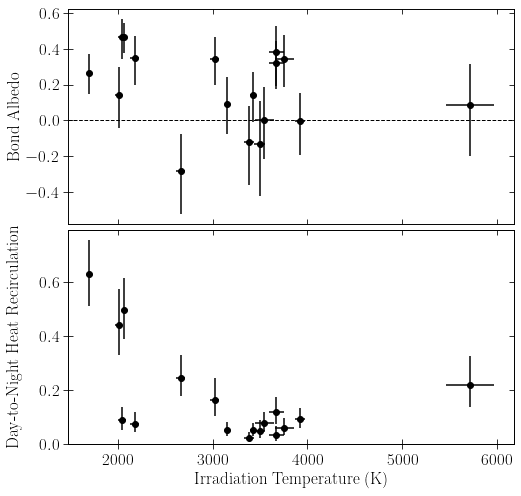

In [7]:
fig1 = make_SchwartzCowan_plot(planets, channels, literature=True, twoD=False, passUncert=True)

HD189733b
1692.7857705382391 0.3318891971835149 0.5463635514542535

WASP-43b
2041.2219793450677 0.4970038443136786 0.05625691835230329

Qatar-1b
2005.418245755 0.36287516081403254 0.13694717770486492

HD209458b
2064.4633116900645 0.38289748588244527 0.5444933400337244

CoRoT-2b
2178.9690061965066 0.24007134424030313 0.1441328407413785

WASP-14b
2661.000504054763 -0.2741834140086248 0.23332563309975957

WASP-19b
3020.211670129808 0.35693287172063703 0.1526538954952204

HAT-P-7b
3146.091382704316 -0.6148789662809254 0.5581352119354743

WASP-18b
3387.576650765641 -0.26809092657455613 0.05490847903175643

KELT-1b
3427.7321098722405 -0.28993246668130956 0.09492818682164254

KELT-16b
3495.8954756157864 -0.17986793304897442 0.04111215869400753

WASP-103b
3546.1715439707887 0.1415674514358259 0.044882903726048154

MASCARA-1b
3751.8389516589104 0.3232586119449866 0.05406701765897845

WASP-12b
3671.454723211884 0.20423882404970178 0.028389325110302184

WASP-12b_old
3670.004805447711 0.2769808449

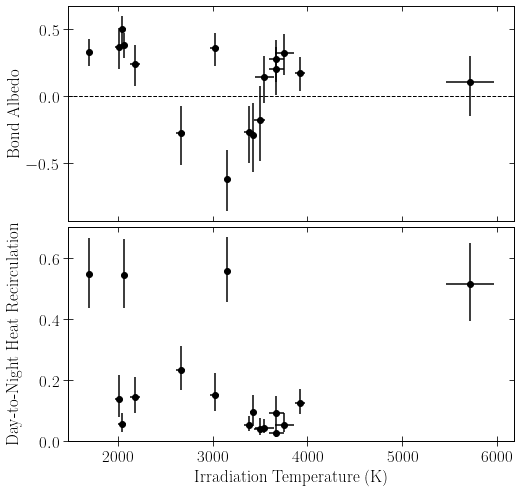

In [8]:
fig2 = make_SchwartzCowan_plot(planets, channels, literature=False, twoD=False)

HD189733b
Knutson+2012
1692.801844591066 0.261477828796651 0.6367351750133183

WASP-43b
Stevenson+2017
2041.329817793886 0.46222776310074515 0.08906944455796423

Qatar-1b
Keating+2020
2005.3667228542865 0.134390719919724 0.463129061749351

HD209458b
Zellem+2014
2064.480498867538 0.47679894907766046 0.4685529114886264

CoRoT-2b
Dang+2018
2178.7923050640497 0.3477808177065712 0.08785694654944642

WASP-14b
Wong+2015
2660.6859494351647 -0.27106977711015423 0.24612353032142015

WASP-19b
Wong+2016
3020.2073603033673 0.34872290072562484 0.16029863152491367

HAT-P-7b
Wong+2016
3146.0904762487908 0.11443215376753113 0.05213628425916593

WASP-18b
Maxted+2013
3387.768384939518 -0.12625741532851276 0.022847424655794892

KELT-1b
Beatty+2019
3427.5331417064313 0.12309557797302229 0.05118972581647715

KELT-16b
3495.567851244042 -0.13229848191274063 0.043999466227302206

WASP-103b
Kreidberg+2018
3545.650636566076 0.026117646779645343 0.07756643373712854

MASCARA-1b
3752.4004800399684 0.320180614165972

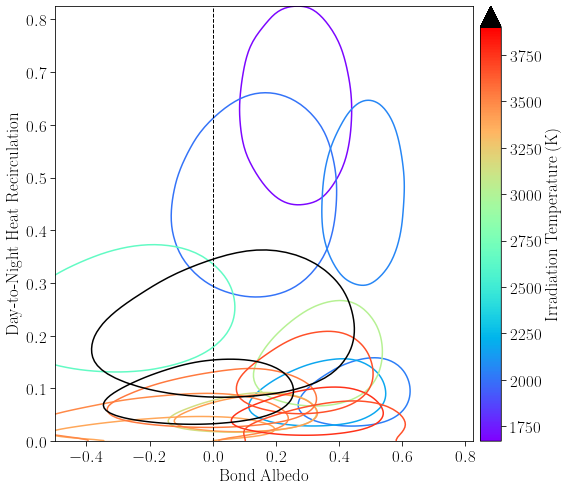

In [9]:
fig3 = make_SchwartzCowan_plot(planets, channels, literature=True, twoD=True)

HD189733b
1692.7895094852295 0.3405658507909843 0.5305650147471485

WASP-43b
2041.177346980426 0.4825074089610899 0.06065792573423914

Qatar-1b
2005.5411277298508 0.3511528395060918 0.12428555518232362

HD209458b
2064.4683474617555 0.38372958685298364 0.5418216924170074

CoRoT-2b
2179.1241544657255 0.2267721322623888 0.14100567961080399

WASP-14b
2660.71778803531 -0.27764947099741255 0.23316169964248645

WASP-19b
3020.397805127165 0.34533847763124437 0.13792745415161706

HAT-P-7b
3146.111507537639 -0.5981008874065247 0.5240938217407474

WASP-18b
3387.6814019154053 -0.2628289982929396 0.05409682403500367

KELT-1b
3427.595020915248 -0.24909107921588636 0.09426732526353147

KELT-16b
3495.028406529199 -0.13287705438566488 0.0450992338408269

WASP-103b
3546.225416040851 0.146762539915196 0.042808741109404316

MASCARA-1b
3751.952716706254 0.33359291438157457 0.05933468721915228

WASP-12b
3671.2546650216455 0.20554134759292436 0.03057151425305692

WASP-12b_old
3669.728330306714 0.276540839458

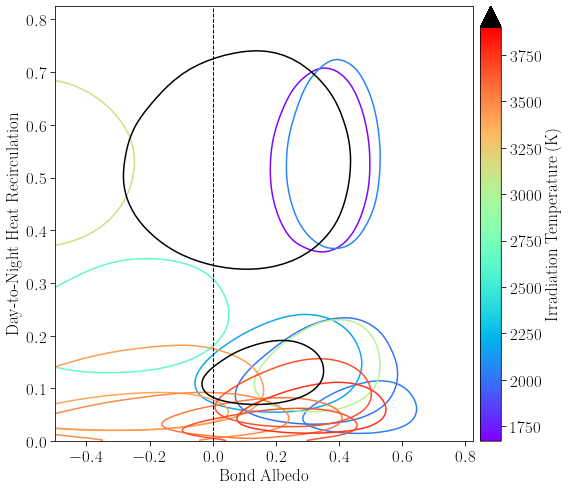

In [10]:
fig4 = make_SchwartzCowan_plot(planets, channels, literature=False, twoD=True)

In [11]:
fig1.savefig('../../MEGA/figures/literature_1D_SchwartzReplica.pdf', bbox_inches='tight')
fig2.savefig('../../MEGA/figures/reanalysis_1D_SchwartzReplica.pdf', bbox_inches='tight')

In [12]:
fig3.savefig('../../MEGA/figures/literature_SchwartzReplica.pdf', bbox_inches='tight')
fig4.savefig('../../MEGA/figures/reanalysis_SchwartzReplica.pdf', bbox_inches='tight')

In [13]:
archiveData = Table.to_pandas(Table.read('../masterfile.ecsv'))
names = np.array(archiveData['pl_hostname'])+np.array(archiveData['pl_letter'])
names = np.array([name.replace(' ','').replace('-', '').replace('_','') for name in names])

In [32]:
plotData = []

for i in tqdm(range(len(planets))):
    channel = channels[i]
    planet = planets[i]
        
    # Figure out where files are saved
    phoption = ''
    foldername = ''
    rms = None
    with open(f'{mainpath}{planet}/analysis/{channel}/bestPhOption.txt') as f:
        lines = f.readlines()
    for i in range(len(lines)):
        if phoption=='' and lines[i][0]=='/':
            foldername = mainpath+lines[i][lines[i].find(planet):].strip()+'/'
            phoption = lines[i].split('/')[-1].strip()
            i += 1
            ignoreFrames = np.array(lines[i].strip().split('=')[1].strip().replace(' ','').split(','))
            if np.all(ignoreFrames==['']):
                ignoreFrames = np.array([]).astype(int)
            else:
                ignoreFrames = ignoreFrames.astype(int)
            i += 1
            rms = float(lines[i])
        elif phoption!='' and lines[i][0]=='/':
            if float(lines[i+2]) < rms:
                foldername = mainpath+lines[i][lines[i].find(planet):].strip()+'/'
                phoption = lines[i].split('/')[-1].strip()
                i += 1
                ignoreFrames = np.array(lines[i].split('=')[1].strip().replace(' ','').split(','))
                if np.all(ignoreFrames==['']):
                    ignoreFrames = np.array([]).astype(int)
                else:
                    ignoreFrames = ignoreFrames.astype(int)
                i += 1
                rms = float(lines[i])
            else:
                i += 3
    pldFoldernames = np.array(['/'.join(foldername.split('/')[:-2])+'/'+np.array(x)[0].split('/')[-1]+'/' for x in os.walk('/'.join(foldername.split('/')[:-2])+'/') if '4umPLD' in x[0].split('/')[-1] or '3umPLD' in x[0].split('/')[-1]])

    # Figure out what modes were run
    modes = np.sort([x[0].split('/')[-1] for x in os.walk(foldername)][1:])
    for i in range(len(pldFoldernames)):
        modes = np.append(modes, np.sort([x[0].split('/')[-1] for x in os.walk(pldFoldernames[i])][1:]))

    #find the best mode
    bestBIC = np.inf
    ResultMCMC = []
    nData = 0
    for mode in modes:
        if 'PLD' in mode:
            if channel=='ch2':
                folder='4um'
            else:
                folder='3um'
            if '3x3' in mode:
                folder += 'PLD_3x3/'
            else:
                folder += 'PLD_5x5/'
            savepath   = '/'.join(foldername.split('/')[:-2])+'/'+folder + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'
        else:
            savepath   = foldername + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'

        if not os.path.exists(savepath):
            continue

        ResultMCMC_temp = np.load(savepath)
        BIC = -2*ResultMCMC_temp['evidenceB'][0]
        if BIC<bestBIC:
            bestBIC = BIC
            ResultMCMC = ResultMCMC_temp
            nData = ResultMCMC['chi2B'][0]/ResultMCMC['chi2datum'][0]

    if bestBIC==np.inf:
        continue #no analyses for this planet
    
    nameIndex = np.where(names==planet.replace(' ','').replace('-', '').split('_')[0])[0][0]
    mass = [archiveData['pl_massj'][nameIndex], np.mean([archiveData['pl_massjerr1'][nameIndex],
                                                         np.abs(archiveData['pl_massjerr2'][nameIndex])])]
    density = [archiveData['pl_dens'][nameIndex], np.mean([archiveData['pl_denserr1'][nameIndex],
                                                           np.abs(archiveData['pl_denserr2'][nameIndex])])]
    period = [archiveData['pl_orbper'][nameIndex], np.mean([archiveData['pl_orbpererr1'][nameIndex],
                                                            np.abs(archiveData['pl_orbpererr2'][nameIndex])])]
    
    feh = [archiveData['st_metfe'][nameIndex], np.mean([archiveData['st_metfeerr1'][nameIndex],
                                                        np.abs(archiveData['st_metfeerr2'][nameIndex])])]
    
    Tstar = [archiveData['st_teff'][nameIndex], np.mean([archiveData['st_tefferr1'][nameIndex],
                                                         np.abs(archiveData['st_tefferr2'][nameIndex])])]
    
    Rstar = [archiveData['st_rad'][nameIndex], np.mean([archiveData['st_raderr1'][nameIndex],
                                                       np.abs(archiveData['st_raderr2'][nameIndex])])]

    if planet=='KELT-1b':
        Tstar = [6518, 50]
        Rstar = [1.462, 0.037]
        feh = [0.052,0.079]
    elif planet=='WASP-33b':
        feh = [0.10,0.]
    elif planet=='MASCARA-1b':
        feh = [0,0]
    
    if np.all(np.isnan(ResultMCMC['fp'])):
        continue
    
    newTb = recompute_Tb(ResultMCMC['fp'], ResultMCMC['rp'], ResultMCMC['A'],
                         planet, channel, mainpath)
    Tday = newTb[[0,1,2]]
    Tnight = newTb[[3,4,5]]
    
    n = int(1.5e5)    
    Tstar = np.random.normal(Tstar[0],  Tstar[1], n)
    a_down = np.random.normal(ResultMCMC['a'][0], ResultMCMC['a'][2], n)
    a_up = np.random.normal(ResultMCMC['a'][0], ResultMCMC['a'][1], n)
    a = np.append(a_down[a_down<ResultMCMC['a'][0]], a_up[a_up>=ResultMCMC['a'][0]])
    
    # Update day and nightside uncertainties using Pass+2019
    bands = np.array([4.493e-6])  # central wavelengths of observed bands (m)
    td_brights = np.array([Tday[0]])  # brightness temperatures in these bands (K)
    td_uncs = np.array([np.mean(Tday[1:])])  # uncertainties on brightness temperatures (K)
    tn_brights = np.array([Tnight[0]])  # brightness temperatures in these bands (K)
    tn_uncs = np.array([np.mean(Tnight[1:])])  # uncertainties on brightness temperatures (K)

    Tday = np.array(pass_uncerts(bands, td_brights, td_uncs))
    Tnight = np.array(pass_uncerts(bands, tn_brights, tn_uncs))

    Td = np.random.normal(Tday[0], Tday[1], n)
    Tn = np.random.normal(Tnight[0], Tday[1], n)
    
    n = np.min([Td.size, Tn.size, Tstar.size, a.size])
    Td = Td[np.random.randint(0, Td.size, Td.size)][np.random.randint(0, Td.size, Td.size)][np.random.randint(0, Td.size, Td.size)][:n]
    Tn = Tn[np.random.randint(0, Tn.size, Tn.size)][np.random.randint(0, Tn.size, Tn.size)][np.random.randint(0, Tn.size, Tn.size)][:n]
    a = a[np.random.randint(0, a.size, a.size)][np.random.randint(0, a.size, a.size)][np.random.randint(0, a.size, a.size)][:n]
    Tstar = Tstar[:n]
    
    T0 = Tstar*np.sqrt(1/a)
    
    eps = 8/(5+3*(Td/Tn)**4) 
    AB = 1-(5*Tn**4+3*Td**4)/(2*T0**4)
    
    Tstar = np.append([np.median(Tstar)], np.mean(np.abs(np.percentile(Tstar, [16, 84])-np.median(Tstar))))
    T0 = np.append([np.median(T0)], np.mean(np.abs(np.percentile(T0, [16, 84])-np.median(T0))))
    eps = np.append([np.median(eps)], np.mean(np.abs(np.percentile(eps, [16, 84])-np.median(eps))))
    AB = np.append([np.median(AB)], np.mean(np.abs(np.percentile(AB, [16, 84])-np.median(AB))))
    
    A = ResultMCMC['A']
    B = ResultMCMC['B']
    
    amp = np.sqrt(A**2+B**2)*2
    amp[1] = np.sqrt((np.mean(A[1:], axis=0)*A[0])**2+(np.mean(B[1:], axis=0)*B[0])**2)/amp[0]
    amp = amp[:2]
    
    A = np.array([A[0], np.mean(np.abs(A[1:]))])
    
    offset = ResultMCMC['offset']
    offset = np.array([offset[0], np.mean(np.abs(offset[1:]))])
    rp_rs = ResultMCMC['rp']
    rp_rs = np.array([rp_rs[0], np.mean(np.abs(rp_rs[1:]))])
    logMass = np.log(mass)
    
    rp_rs_sim = np.random.normal(rp_rs[0], rp_rs[1], int(1e5))
    rs_sim = np.random.normal(Rstar[0], Rstar[1], int(1e5))
    mass_sim = np.random.normal(mass[0], mass[1], int(1e5))
    rp_sim = rp_rs_sim*rs_sim*const.R_sun.value/const.R_jup.value
    rp = [np.median(rp_sim), np.mean(np.abs(np.percentile(rp_sim, [16, 84])-np.median(rp_sim)))]
    
    logg_pl_sim = np.log(const.G.value*mass_sim*const.M_jup.value/((rp_sim*const.R_jup.value)**2))
    logg_pl = [np.nanmedian(logg_pl_sim), np.nanmean(np.abs(np.nanpercentile(logg_pl_sim, [16, 84])-np.nanmedian(logg_pl_sim)))]
    
    plotData.append([Tstar, T0, Tday, Tnight, A, offset, eps, AB, rp, mass, logMass, density, logg_pl, period, feh, amp])
    
plotData = np.array(plotData)

100%|██████████| 17/17 [01:34<00:00,  5.56s/it]


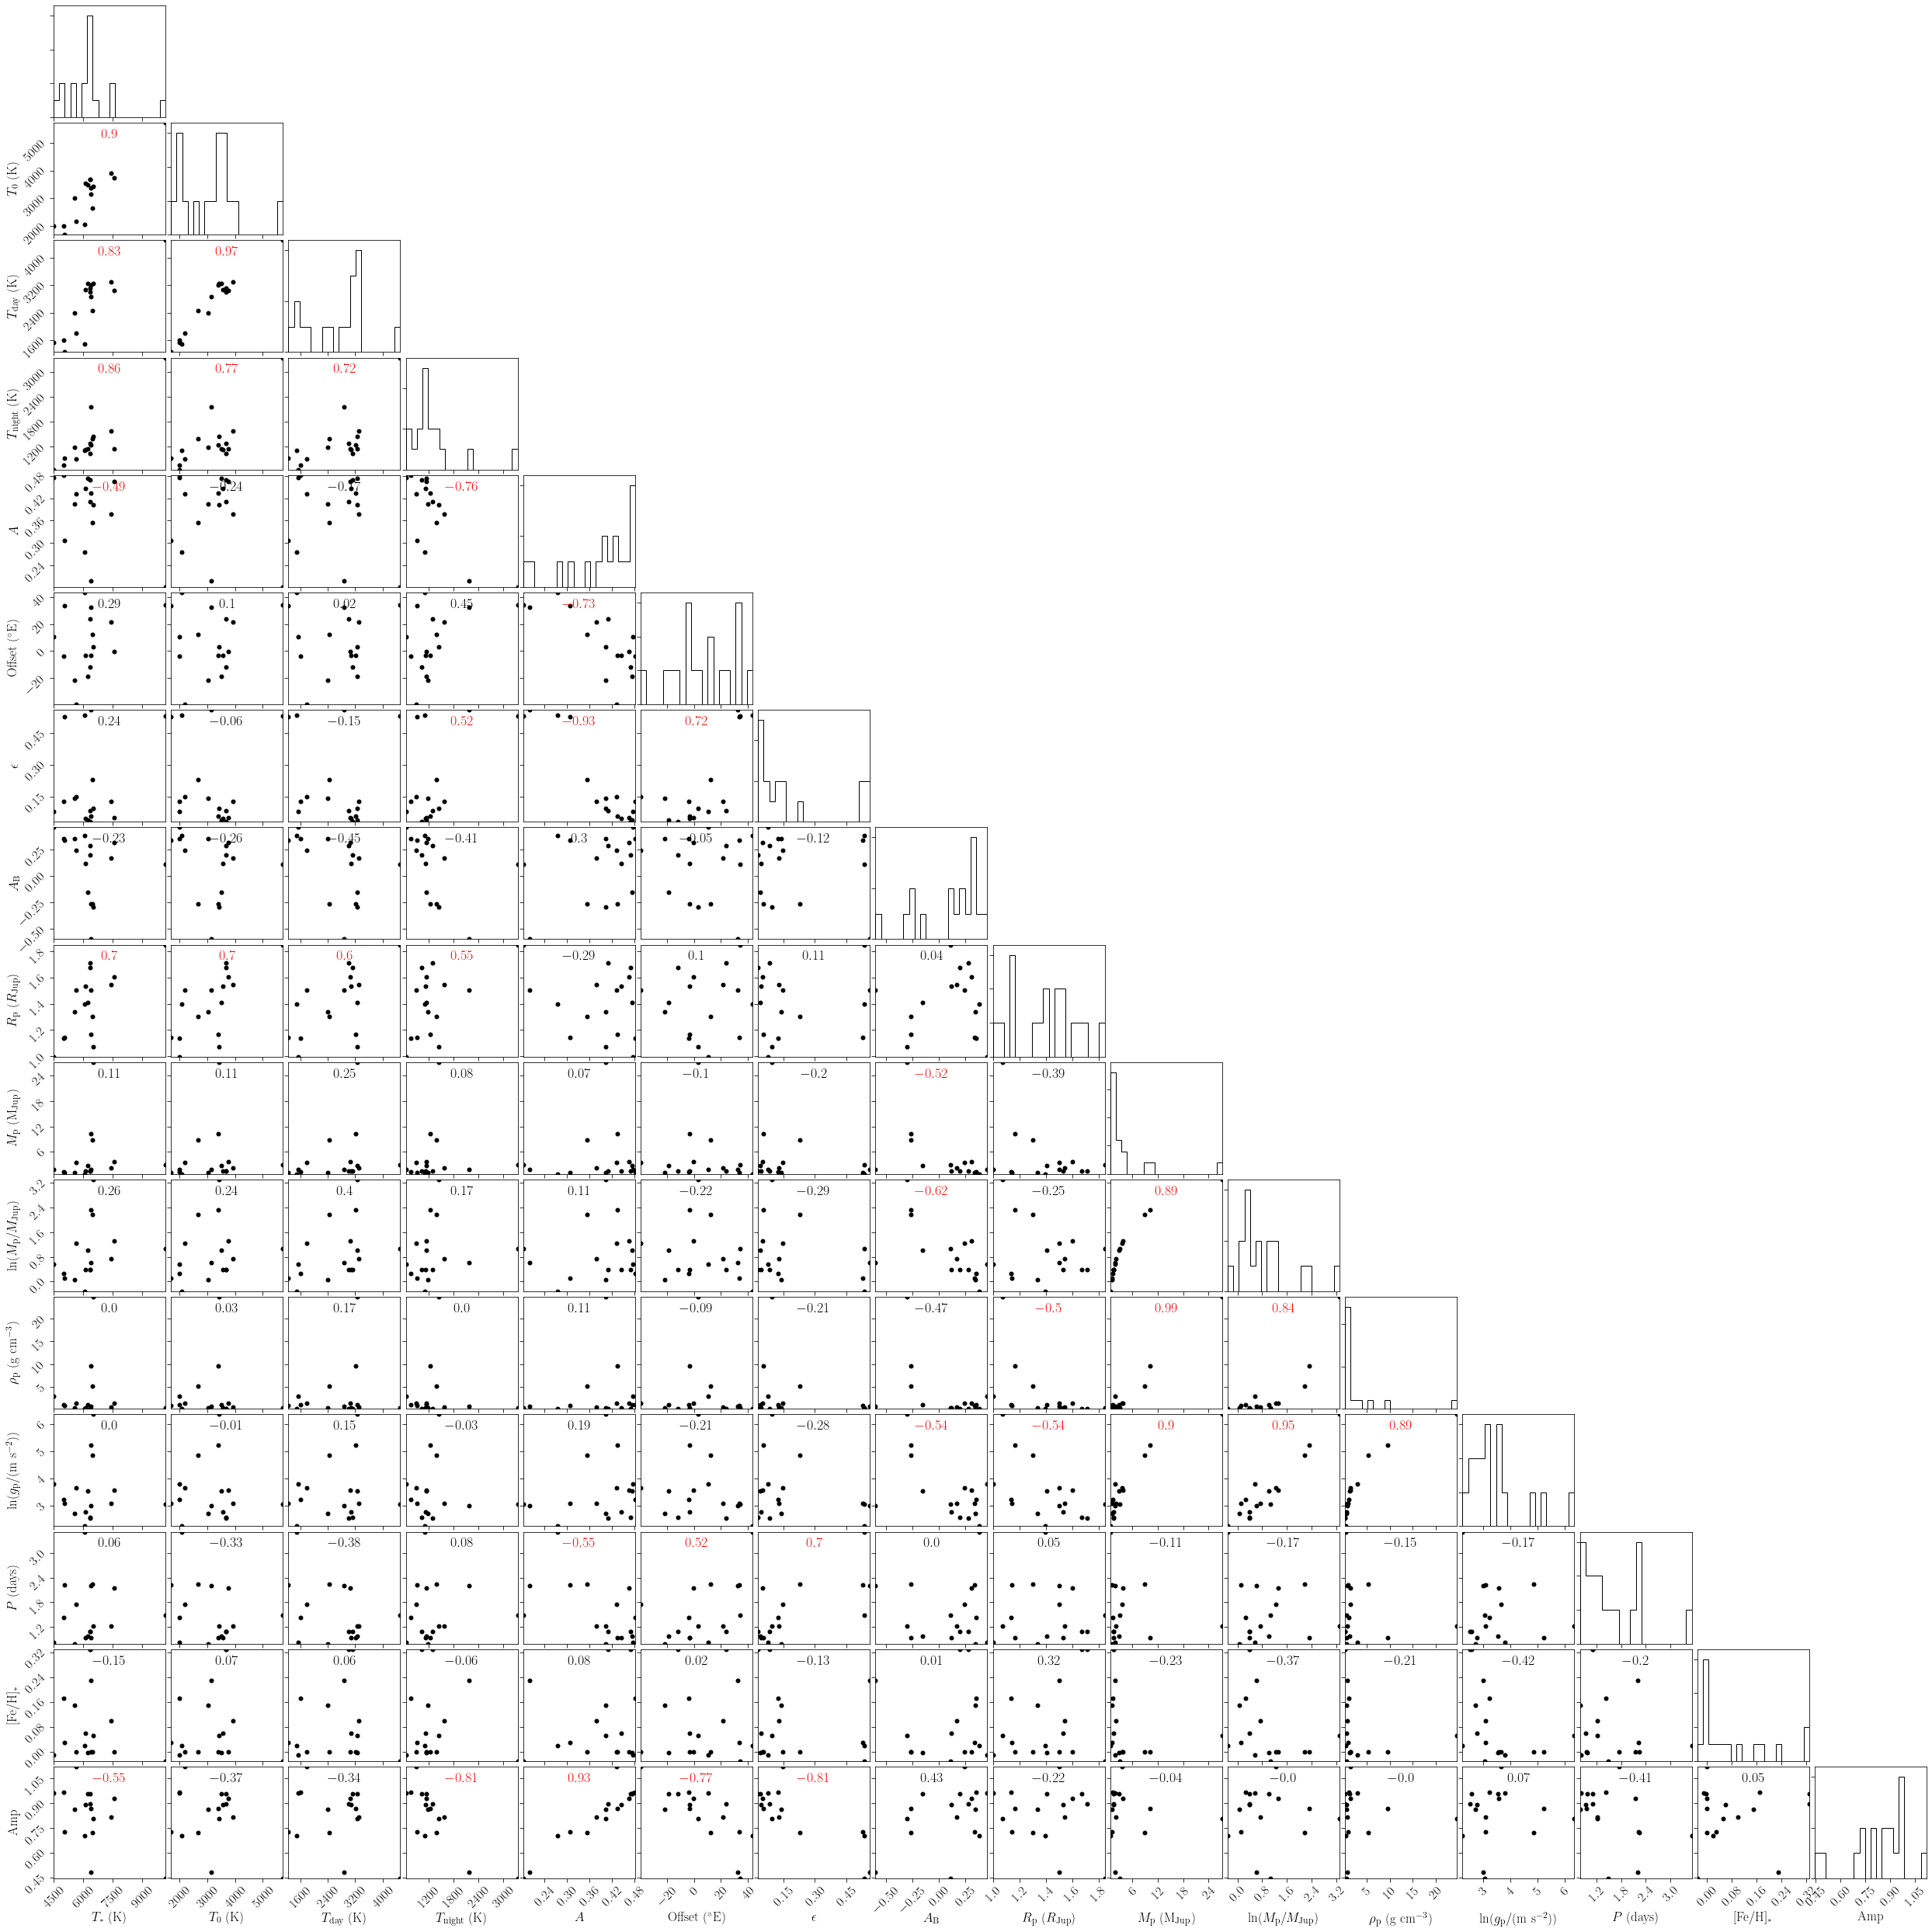

In [33]:
labels=[r'$T_{\rm *}~\rm (K)$', r'$T_{\rm 0}~\rm (K)$', r'$T_{\rm day}~\rm (K)$', r'$T_{\rm night}~\rm (K)$',
        r'$A$', r'$\rm Offset~\rm (^{\circ}E)$', r'$\epsilon$', r'$A_{\rm B}$',
        r'$R_{\rm p}~(R_{\rm Jup})$', r'$M_{\rm p}~\rm (M_{\rm Jup})$', r'$\ln(M_{\rm p}/M_{\rm Jup})$',
        r'$\rho_{\rm p}~\rm (g~cm^{-3})$', r'$\ln(g_{\rm p} / ({\rm m~s^{-2}}))$', r'$P~\rm (days)$',
        r'$\rm [Fe/H]_{\rm *}$', r'$\rm Amp$']

corner.corner(plotData[:,:,0], labels=labels,
       plot_datapoints=True, plot_density=False, plot_contours=False, data_kwargs={'ms':6, 'alpha':1, 'color':'k'})
figure = plt.gcf()

axes = np.array(figure.get_axes()).reshape(plotData.shape[1], plotData.shape[1])
for indX, x in enumerate(plotData[:,:,0].T):
    nameX = labels[indX]
    for indY, y in enumerate(plotData[:,(indX+1):,0].T):
        nameY = labels[(indX+1):][indY]
        r = pearsonr(x,y)
        axes[indY+indX+1, indX].text(0.5, 0.95, '$'+str(np.round(r[0], 2))+'$', horizontalalignment='center', verticalalignment='top', transform=axes[indY+indX+1, indX].transAxes, color=['black', 'red'][int(r[1]<0.05)], fontsize=18)

figure.patch.set_facecolor('white')
        
figure.savefig('../../MEGA/figures/populationCorrelations_corner.pdf', bbox_inches='tight')
figure.savefig('../../MEGA/figures/populationCorrelations_corner.png', dpi=300, bbox_inches='tight')
# plt.show()

In [34]:
print(planets[np.isin(planets,['KELT-16b', 'MASCARA-1b'])])
print(plotData[np.isin(planets,['KELT-16b', 'MASCARA-1b']),np.array(labels)==r'$\epsilon$',:])

['KELT-16b' 'MASCARA-1b']
[[0.03967602 0.0258167 ]
 [0.04971592 0.02809866]]


1
(0.8964290188365871, 1.114031254093431e-06)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    -5299.4 +/-     1758.5          Guessed: -1319.6   
   p[1] =     1.2808 +/-     0.2969          Guessed: 0.70279   


100%|██████████| 10001/10001 [00:05<00:00, 1710.43it/s]


**** MC uncertainty finding has finished
   p[0] =    -5297.7 +/-     204.92          Guessed: -1319.6   
   p[0] Bias : -0.0003336 +/- 0.004159  (  -0.08 SD)
   p[1] =     1.2805 +/-   0.034486          Guessed: 0.70279   
   p[1] Bias : -0.0002582 +/- 0.002905  (  -0.09 SD)


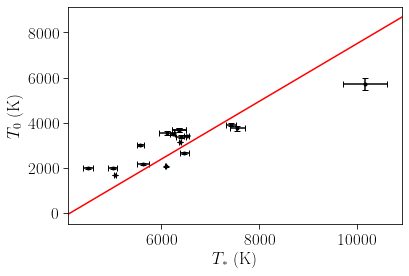

2
(0.8343705840599908, 3.121816027704628e-05)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    -2743.6 +/-     996.96          Guessed: -1021.5   
   p[1] =    0.82541 +/-    0.16905          Guessed: 0.57957   


100%|██████████| 10001/10001 [00:04<00:00, 2238.29it/s]


**** MC uncertainty finding has finished
   p[0] =    -2742.3 +/-     286.85          Guessed: -1021.5   
   p[0] Bias : -0.0004919 +/- 0.004554  (  -0.11 SD)
   p[1] =    0.82548 +/-   0.048105          Guessed: 0.57957   
   p[1] Bias : +8.235e-05 +/- 0.002567  (   0.03 SD)


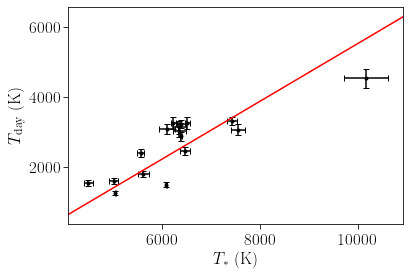

3
(0.8640891114780661, 7.756980830243864e-06)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    -1003.4 +/-     271.68          Guessed: -1412.7   
   p[1] =    0.36025 +/-   0.045954          Guessed: 0.42957   


100%|██████████| 10001/10001 [00:03<00:00, 2540.45it/s]


**** MC uncertainty finding has finished
   p[0] =    -1002.9 +/-     161.78          Guessed: -1412.7   
   p[0] Bias : -0.000506 +/- 0.003394  (  -0.15 SD)
   p[1] =     0.3601 +/-   0.027502          Guessed: 0.42957   
   p[1] Bias : -0.0004059 +/- 0.001599  (  -0.25 SD)


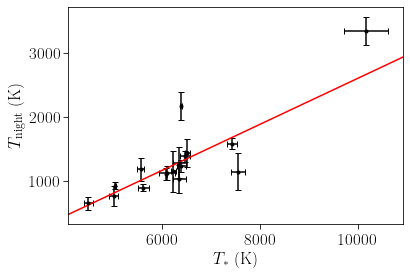

4
(-0.4872153150016763, 0.04729709312434921)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    0.64557 +/-   0.068125          Guessed: 0.61909   
   p[1] = -3.8248e-05 +/-  1.016e-05          Guessed: -3.6468e-05


100%|██████████| 10001/10001 [00:04<00:00, 2215.36it/s]


**** MC uncertainty finding has finished
   p[0] =    0.64575 +/-   0.022085          Guessed: 0.61909   
   p[0] Bias : +0.0002818 +/- 0.001323  (   0.21 SD)
   p[1] = -3.8244e-05 +/- 3.3254e-06          Guessed: -3.6468e-05
   p[1] Bias : -0.0001052 +/- 0.003329  (  -0.03 SD)


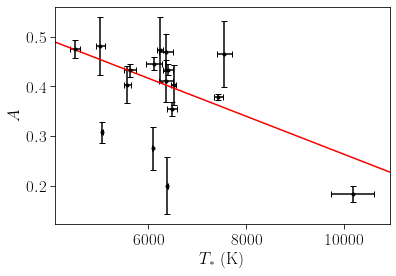

5
(0.6976768164351557, 0.0018471099225391627)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    0.22518 +/-    0.21536          Guessed: 0.55303   
   p[1] = 0.00018237 +/-  3.801e-05          Guessed: 0.00013419


100%|██████████| 10001/10001 [00:04<00:00, 2285.45it/s]


**** MC uncertainty finding has finished
   p[0] =    0.22421 +/-   0.061782          Guessed: 0.55303   
   p[0] Bias : -0.0043   +/- 0.01199   (  -0.36 SD)
   p[1] = 0.00018251 +/- 1.0962e-05          Guessed: 0.00013419
   p[1] Bias : +0.0007913 +/- 0.002612  (   0.30 SD)


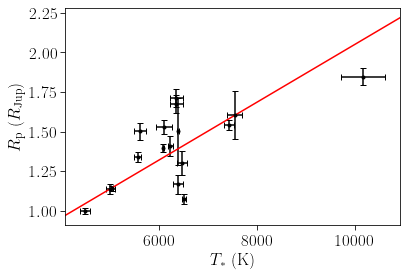

6
(-0.5505967081207679, 0.021999295957588424)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =     1.3735 +/-    0.21028          Guessed: 1.3128    
   p[1] = -8.7608e-05 +/- 3.5473e-05          Guessed: -7.587e-05


100%|██████████| 10001/10001 [00:08<00:00, 1192.31it/s]


**** MC uncertainty finding has finished
   p[0] =     1.3734 +/-   0.028736          Guessed: 1.3128    
   p[0] Bias : -2.432e-05 +/- 0.001919  (  -0.01 SD)
   p[1] = -8.765e-05 +/- 5.2704e-06          Guessed: -7.587e-05
   p[1] Bias : +0.0004776 +/- 0.005075  (   0.09 SD)


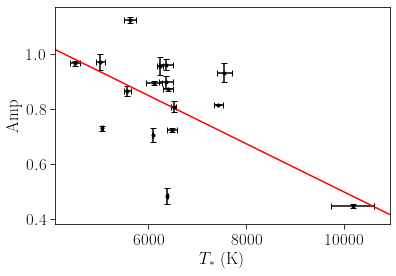

7
(0.970439234359479, 1.1421310026465551e-10)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    -426.27 +/-     131.35          Guessed: -43.585   
   p[1] =    0.98888 +/-   0.050193          Guessed: 0.85981   


100%|██████████| 10001/10001 [00:03<00:00, 2892.49it/s]


**** MC uncertainty finding has finished
   p[0] =    -426.72 +/-     96.753          Guessed: -43.585   
   p[0] Bias : +0.001052 +/- 0.003862  (   0.27 SD)
   p[1] =    0.98914 +/-    0.03708          Guessed: 0.85981   
   p[1] Bias : +0.0002576 +/- 0.0006362 (   0.40 SD)


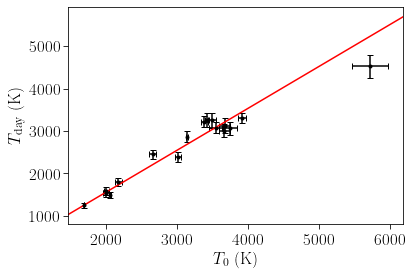

8
(0.7699592152425844, 0.0003000920551448177)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =     191.59 +/-     190.78          Guessed: -220.03   
   p[1] =    0.35844 +/-   0.071055          Guessed: 0.48824   


100%|██████████| 10001/10001 [00:03<00:00, 2578.18it/s]


**** MC uncertainty finding has finished
   p[0] =     193.25 +/-     81.761          Guessed: -220.03   
   p[0] Bias : +0.008678 +/- 0.01248   (   0.70 SD)
   p[1] =    0.35786 +/-   0.030601          Guessed: 0.48824   
   p[1] Bias : -0.001615 +/- 0.002485  (  -0.65 SD)


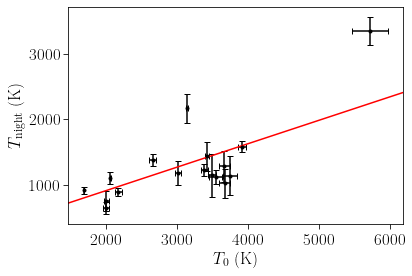

9
(0.7026708159098933, 0.001656927562216334)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    0.80666 +/-     0.1162          Guessed: 0.86324   
   p[1] = 0.00017764 +/- 4.5778e-05          Guessed: 0.00017239


100%|██████████| 10001/10001 [00:04<00:00, 2462.33it/s]


**** MC uncertainty finding has finished
   p[0] =    0.80708 +/-   0.023211          Guessed: 0.86324   
   p[0] Bias : +0.0005215 +/- 0.001806  (   0.29 SD)
   p[1] = 0.00017748 +/-  9.404e-06          Guessed: 0.00017239
   p[1] Bias : -0.0008643 +/- 0.00323   (  -0.27 SD)


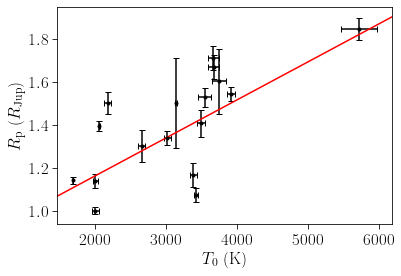

10
(0.7182345845476352, 0.0011643896018755056)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =     299.19 +/-     188.14          Guessed: -52.408   
   p[1] =    0.38271 +/-   0.083395          Guessed: 0.51405   


100%|██████████| 10001/10001 [00:04<00:00, 2109.25it/s]


**** MC uncertainty finding has finished
   p[0] =     299.39 +/-     85.292          Guessed: -52.408   
   p[0] Bias : +0.0006699 +/- 0.007882  (   0.08 SD)
   p[1] =    0.38306 +/-   0.038972          Guessed: 0.51405   
   p[1] Bias : +0.0009019 +/- 0.002731  (   0.33 SD)


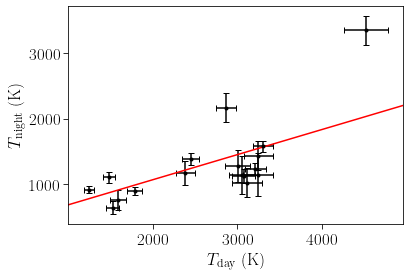

11
(0.6035225354851558, 0.010313509889299403)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    0.77239 +/-    0.12596          Guessed: 0.96061   
   p[1] = 0.00024637 +/- 6.0472e-05          Guessed: 0.00016712


100%|██████████| 10001/10001 [00:05<00:00, 1694.38it/s]


**** MC uncertainty finding has finished
   p[0] =    0.77249 +/-   0.035381          Guessed: 0.96061   
   p[0] Bias : +0.0001373 +/- 0.002044  (   0.07 SD)
   p[1] =  0.0002464 +/- 1.8095e-05          Guessed: 0.00016712
   p[1] Bias : +0.0001184 +/- 0.003076  (   0.04 SD)


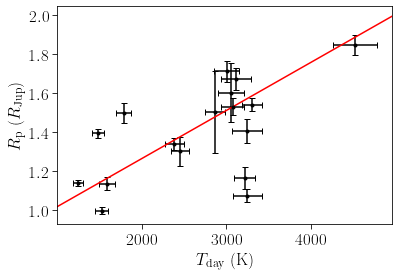

12
(-0.7634490771651805, 0.0003624165369309572)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    0.53259 +/-    0.03066          Guessed: 0.5386    
   p[1] = -0.00010754 +/- 2.2865e-05          Guessed: -0.00011494


100%|██████████| 10001/10001 [00:04<00:00, 2067.86it/s]


**** MC uncertainty finding has finished
   p[0] =    0.53313 +/-   0.016585          Guessed: 0.5386    
   p[0] Bias : +0.001009 +/- 0.0007215 (   1.40 SD)
   p[1] = -0.00010777 +/- 1.3518e-05          Guessed: -0.00011494
   p[1] Bias : +0.002209 +/- 0.002665  (   0.83 SD)


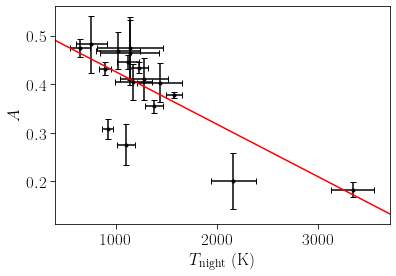

13
(0.5249170988216441, 0.030501401399688013)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =   -0.12943 +/-   0.089948          Guessed: -0.019679 
   p[1] = 0.00019722 +/- 7.7619e-05          Guessed: 0.00016769


100%|██████████| 10001/10001 [00:08<00:00, 1203.57it/s]


**** MC uncertainty finding has finished
   p[0] =   -0.12872 +/-   0.055246          Guessed: -0.019679 
   p[0] Bias : -0.005512 +/- 0.00871   (  -0.63 SD)
   p[1] = 0.00019704 +/- 5.3221e-05          Guessed: 0.00016769
   p[1] Bias : -0.0009313 +/- 0.004933  (  -0.19 SD)


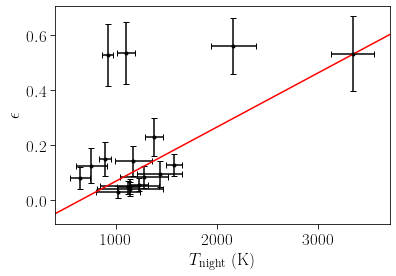

14
(0.5513022692799588, 0.021795079092179745)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    0.67337 +/-    0.16173          Guessed: 1.1244    
   p[1] = 0.00057281 +/- 0.00014267          Guessed: 0.0002133 


100%|██████████| 10001/10001 [00:06<00:00, 1644.76it/s]


**** MC uncertainty finding has finished
   p[0] =    0.67143 +/-   0.075302          Guessed: 1.1244    
   p[0] Bias : -0.00288  +/- 0.00301   (  -0.96 SD)
   p[1] = 0.00057414 +/-  6.908e-05          Guessed: 0.0002133 
   p[1] Bias : +0.002321 +/- 0.003122  (   0.74 SD)


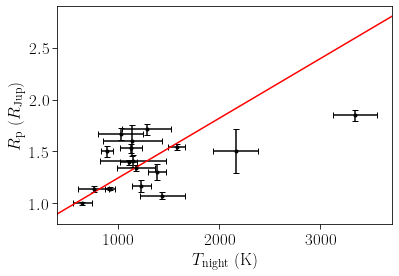

15
(-0.8112516602867448, 7.744516245262877e-05)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =     1.6703 +/-    0.33142          Guessed: 1.1266    
   p[1] = -0.00073143 +/- 0.00029358          Guessed: -0.00022486


100%|██████████| 10001/10001 [00:09<00:00, 1072.16it/s]


**** MC uncertainty finding has finished
   p[0] =     1.6694 +/-    0.12434          Guessed: 1.1266    
   p[0] Bias : -0.0005229 +/- 0.002487  (  -0.21 SD)
   p[1] = -0.00073031 +/- 0.00011154          Guessed: -0.00022486
   p[1] Bias : -0.001524 +/- 0.005031  (  -0.30 SD)


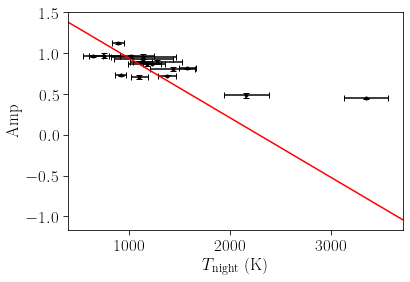

16
(-0.7299639061381636, 0.0008790707631294083)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =     158.42 +/-     37.168          Guessed: 75.189    
   p[1] =    -381.79 +/-      95.59          Guessed: -176.67   


100%|██████████| 10001/10001 [00:05<00:00, 1684.15it/s]


**** MC uncertainty finding has finished
   p[0] =      158.6 +/-     15.266          Guessed: 75.189    
   p[0] Bias : +0.001099 +/- 0.002941  (   0.37 SD)
   p[1] =    -382.55 +/-     39.946          Guessed: -176.67   
   p[1] Bias : +0.001993 +/- 0.003138  (   0.64 SD)


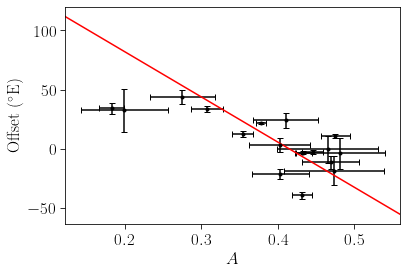

17
(-0.9278547512883406, 8.123670338884168e-08)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    0.95647 +/-     0.1284          Guessed: 0.96378   
   p[1] =    -2.0247 +/-    0.30495          Guessed: -1.9688   


100%|██████████| 10001/10001 [00:04<00:00, 2018.98it/s]


**** MC uncertainty finding has finished
   p[0] =    0.95573 +/-    0.14165          Guessed: 0.96378   
   p[0] Bias : -0.0007755 +/- 0.001683  (  -0.46 SD)
   p[1] =    -2.0219 +/-     0.3379          Guessed: -1.9688   
   p[1] Bias : -0.001348 +/- 0.001888  (  -0.71 SD)


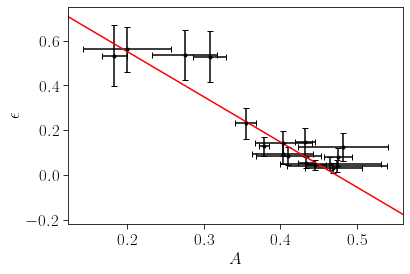

18
(-0.5493847347573586, 0.02235355945863129)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Iteration limit reached
   p[0] =     3.2941 +/-     0.4803          Guessed: 3.1802    
   p[1] =    -5.1167 +/-     1.2254          Guessed: -4.2509   


100%|██████████| 10001/10001 [00:25<00:00, 396.39it/s]


**** MC uncertainty finding has finished
   p[0] =     3.5247 +/-     1.0172          Guessed: 3.1802    
   p[0] Bias : +0.07002  +/- 0.001828  (  38.32 SD)
   p[1] =    -5.6926 +/-     2.6349          Guessed: -4.2509   
   p[1] Bias : +0.1126   +/- 0.003002  (  37.50 SD)


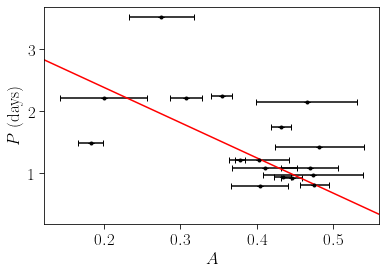

19
(0.9299083169075516, 6.581523071850561e-08)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =  -0.085601 +/-    0.12927          Guessed: 0.16767   
   p[1] =     2.3782 +/-    0.33187          Guessed: 1.7119    


100%|██████████| 10001/10001 [00:04<00:00, 2225.62it/s]


**** MC uncertainty finding has finished
   p[0] =  -0.084613 +/-   0.068486          Guessed: 0.16767   
   p[0] Bias : -0.01153  +/- 0.01893   (  -0.61 SD)
   p[1] =     2.3759 +/-    0.17636          Guessed: 1.7119    
   p[1] Bias : -0.0009469 +/- 0.001749  (  -0.54 SD)


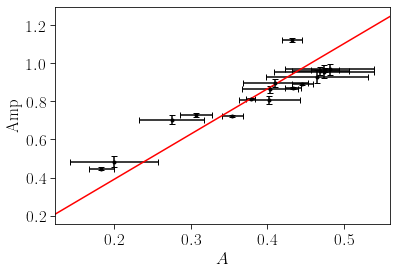

20
(0.7200273707506408, 0.0011164072619807585)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    0.08693 +/-   0.020964          Guessed: 0.15821   
   p[1] =  0.0039364 +/-  0.0014185          Guessed: 0.0063125 


100%|██████████| 10001/10001 [00:06<00:00, 1554.47it/s]


**** MC uncertainty finding has finished
   p[0] =   0.086621 +/-    0.01101          Guessed: 0.15821   
   p[0] Bias : -0.003566 +/- 0.003023  (  -1.18 SD)
   p[1] =  0.0039347 +/- 0.00089815          Guessed: 0.0063125 
   p[1] Bias : -0.0004264 +/- 0.004517  (  -0.09 SD)


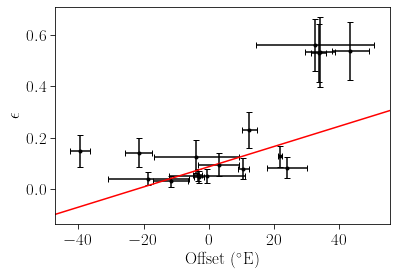

21
(0.5246142935231077, 0.030614807694735756)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Iteration limit reached
   p[0] =    0.90889 +/-    0.14594          Guessed: 1.4198    
   p[1] =   0.020786 +/-  0.0055819          Guessed: 0.016772  


100%|██████████| 10001/10001 [00:25<00:00, 395.88it/s]


**** MC uncertainty finding has finished
   p[0] =     1.0894 +/-   0.064697          Guessed: 1.4198    
   p[0] Bias : +0.1986   +/- 0.002012  (  98.69 SD)
   p[1] =   0.021864 +/-  0.0043629          Guessed: 0.016772  
   p[1] Bias : +0.05186  +/- 0.003366  (  15.41 SD)


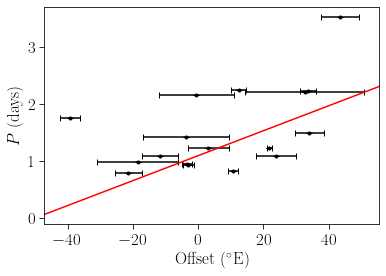

22
(-0.7740686443592764, 0.0002655677945483787)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    0.92537 +/-    0.02761          Guessed: 0.87083   
   p[1] = -0.0069735 +/-  0.0014756          Guessed: -0.005888 


100%|██████████| 10001/10001 [00:05<00:00, 1826.82it/s]


**** MC uncertainty finding has finished
   p[0] =    0.92547 +/-   0.006456          Guessed: 0.87083   
   p[0] Bias : +0.0001123 +/- 0.000374  (   0.30 SD)
   p[1] = -0.0069754 +/- 0.00035125          Guessed: -0.005888 
   p[1] Bias : +0.0002639 +/- 0.002652  (   0.10 SD)


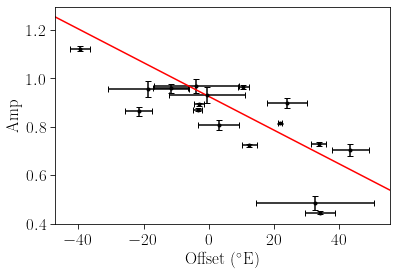

23
(0.6966163365935938, 0.0018897135911545967)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Iteration limit reached
   p[0] =    0.92393 +/-    0.12461          Guessed: 1.0228    
   p[1] =      3.793 +/-    0.88223          Guessed: 2.5403    


100%|██████████| 10001/10001 [00:22<00:00, 438.44it/s]


**** MC uncertainty finding has finished
   p[0] =    0.90292 +/-    0.19759          Guessed: 1.0228    
   p[0] Bias : -0.02273  +/- 0.00169   ( -13.45 SD)
   p[1] =     4.8223 +/-     2.2117          Guessed: 2.5403    
   p[1] Bias : +0.2713   +/- 0.002915  (  93.08 SD)


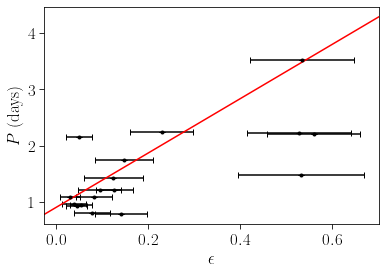

24
(-0.8133601327695557, 7.165464856948099e-05)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =     1.0074 +/-   0.037941          Guessed: 0.97289   
   p[1] =    -1.3561 +/-    0.36971          Guessed: -0.7057   


100%|██████████| 10001/10001 [00:07<00:00, 1310.12it/s]


**** MC uncertainty finding has finished
   p[0] =     1.0083 +/-   0.024082          Guessed: 0.97289   
   p[0] Bias : +0.0009496 +/- 0.0004721 (   2.01 SD)
   p[1] =    -1.3596 +/-    0.25259          Guessed: -0.7057   
   p[1] Bias : +0.002612 +/- 0.003417  (   0.76 SD)


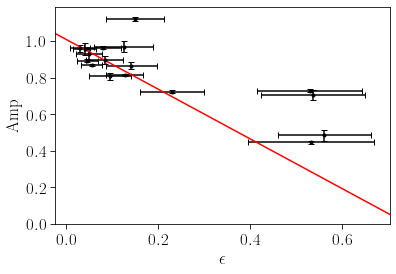

25
(-0.517466164941935, 0.03338719923438882)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =     9.5918 +/-     3.0088          Guessed: 5.4599    
   p[1] =    -29.795 +/-     11.142          Guessed: -10.942   


100%|██████████| 10001/10001 [00:10<00:00, 965.68it/s]


**** MC uncertainty finding has finished
   p[0] =     9.6187 +/-     3.8872          Guessed: 5.4599    
   p[0] Bias : +0.002811 +/- 0.003932  (   0.72 SD)
   p[1] =    -29.754 +/-     15.549          Guessed: -10.942   
   p[1] Bias : -0.001378 +/- 0.004687  (  -0.29 SD)


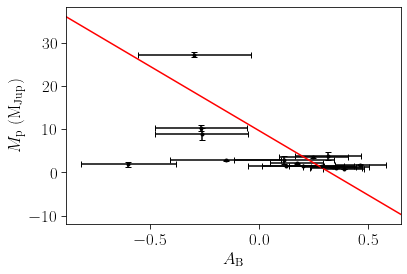

26
(-0.6185136560617263, 0.00812701272648282)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =     1.5754 +/-    0.20027          Guessed: 1.1171    
   p[1] =    -2.0401 +/-    0.78493          Guessed: -1.8866   


100%|██████████| 10001/10001 [00:08<00:00, 1135.40it/s]


**** MC uncertainty finding has finished
   p[0] =      1.551 +/-     1.2023          Guessed: 1.1171    
   p[0] Bias : -0.01545  +/- 0.001593  (  -9.70 SD)
   p[1] =    -1.9699 +/-      5.629          Guessed: -1.8866   
   p[1] Bias : -0.03441  +/- 0.004822  (  -7.14 SD)


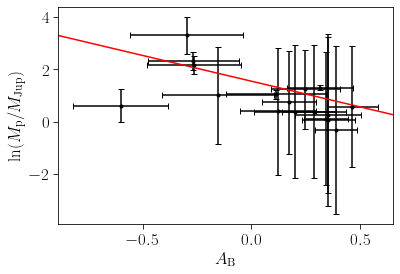

27
(-0.5394255496696092, 0.025435380327148354)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =      4.602 +/-    0.64149          Guessed: 3.6779    
   p[1] =    -6.1054 +/-     2.3818          Guessed: -1.9071   


100%|██████████| 10001/10001 [00:08<00:00, 1214.67it/s]


**** MC uncertainty finding has finished
   p[0] =     4.6048 +/-     1.3704          Guessed: 3.6779    
   p[0] Bias : +0.0006072 +/- 0.001747  (   0.35 SD)
   p[1] =    -6.0895 +/-     5.6435          Guessed: -1.9071   
   p[1] Bias : -0.002598 +/- 0.00489   (  -0.53 SD)


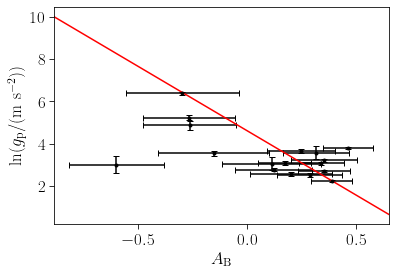

28
(-0.4966028195831946, 0.04258388837811988)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =     4.0188 +/-     1.5458          Guessed: 20.502    
   p[1] =    -2.4094 +/-     1.0943          Guessed: -12.392   


100%|██████████| 10001/10001 [00:06<00:00, 1588.48it/s]


**** MC uncertainty finding has finished
   p[0] =     4.0188 +/-    0.35325          Guessed: 20.502    
   p[0] Bias : -9.479e-06 +/- 0.004821  (  -0.00 SD)
   p[1] =    -2.4092 +/-     0.2477          Guessed: -12.392   
   p[1] Bias : -9.317e-05 +/- 0.005692  (  -0.02 SD)


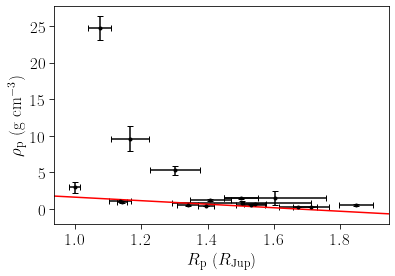

29
(-0.5449575123963916, 0.02368548360876682)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =     11.226 +/-     2.5072          Guessed: 6.8946    
   p[1] =    -6.2863 +/-      2.014          Guessed: -2.4321   


100%|██████████| 10001/10001 [00:06<00:00, 1541.42it/s]


**** MC uncertainty finding has finished
   p[0] =     11.236 +/-    0.53727          Guessed: 6.8946    
   p[0] Bias : +0.0009049 +/- 0.002799  (   0.32 SD)
   p[1] =    -6.2926 +/-      0.441          Guessed: -2.4321   
   p[1] Bias : +0.001005 +/- 0.004016  (   0.25 SD)


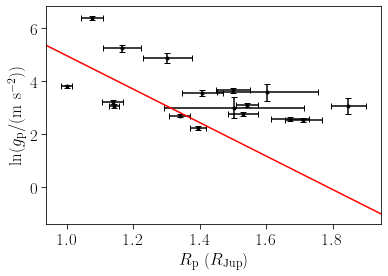

30
(0.8901058337444383, 1.7048693804201712e-06)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    0.82821 +/-    0.16323          Guessed: 0.36583   
   p[1] =    0.11866 +/-   0.025306          Guessed: 0.1284    


100%|██████████| 10001/10001 [00:03<00:00, 2701.77it/s]


**** MC uncertainty finding has finished
   p[0] =    0.82719 +/-    0.16508          Guessed: 0.36583   
   p[0] Bias : -0.001231 +/- 0.00247   (  -0.50 SD)
   p[1] =    0.11935 +/-    0.02493          Guessed: 0.1284    
   p[1] Bias : +0.005766 +/- 0.002673  (   2.16 SD)


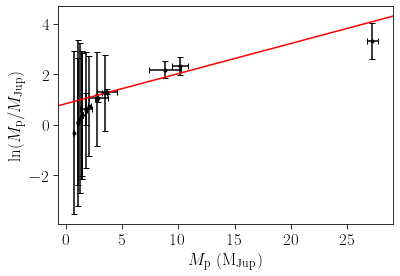

31
(0.9867052051835713, 2.9881091231057603e-13)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =   -0.42813 +/-    0.23785          Guessed: -0.8858   
   p[1] =    0.83095 +/-     0.1968          Guessed: 0.92247   


100%|██████████| 10001/10001 [00:05<00:00, 1716.26it/s]


**** MC uncertainty finding has finished
   p[0] =   -0.42817 +/-   0.079756          Guessed: -0.8858   
   p[0] Bias : +8.059e-05 +/- 0.006963  (   0.01 SD)
   p[1] =    0.83156 +/-   0.070563          Guessed: 0.92247   
   p[1] Bias : +0.0007391 +/- 0.002969  (   0.25 SD)


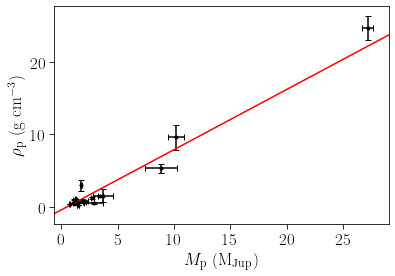

32
(0.9009953197243804, 8.053036147746115e-07)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =     2.7459 +/-    0.13116          Guessed: 2.8284    
   p[1] =    0.14631 +/-   0.020379          Guessed: 0.15065   


100%|██████████| 10001/10001 [00:03<00:00, 2773.25it/s]


**** MC uncertainty finding has finished
   p[0] =     2.7457 +/-   0.025573          Guessed: 2.8284    
   p[0] Bias : -6.937e-05 +/- 0.0005987 (  -0.12 SD)
   p[1] =    0.14626 +/-  0.0042192          Guessed: 0.15065   
   p[1] Bias : -0.0003186 +/- 0.001746  (  -0.18 SD)


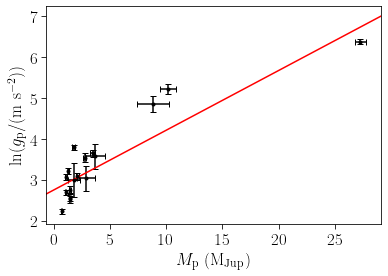

33
(0.8402844466548419, 2.4202625840325127e-05)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    -9.3731 +/-     2.8172          Guessed: -1.9139   
   p[1] =     8.6092 +/-     1.9379          Guessed: 5.4458    


100%|██████████| 10001/10001 [00:06<00:00, 1457.76it/s]


**** MC uncertainty finding has finished
   p[0] =    -9.3872 +/-     3.3198          Guessed: -1.9139   
   p[0] Bias : +0.001503 +/- 0.003767  (   0.40 SD)
   p[1] =     8.6116 +/-     2.2747          Guessed: 5.4458    
   p[1] Bias : +0.0002795 +/- 0.002821  (   0.10 SD)


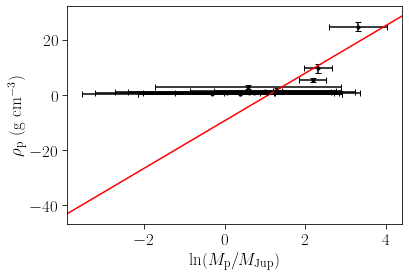

34
(0.948617790443976, 6.773501611897443e-09)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =     1.6169 +/-    0.55225          Guessed: 2.4671    
   p[1] =     1.5015 +/-    0.33013          Guessed: 1.0995    


100%|██████████| 10001/10001 [00:05<00:00, 1989.83it/s]


**** MC uncertainty finding has finished
   p[0] =     1.6114 +/-    0.67634          Guessed: 2.4671    
   p[0] Bias : -0.003445 +/- 0.004281  (  -0.80 SD)
   p[1] =     1.5008 +/-    0.41835          Guessed: 1.0995    
   p[1] Bias : -0.0004801 +/- 0.002756  (  -0.17 SD)


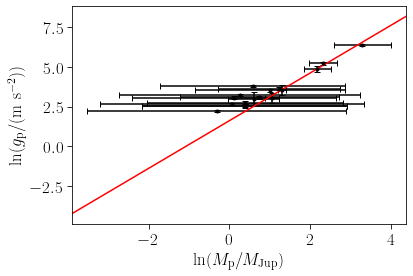

35
(0.8926848367842064, 1.4378017869777428e-06)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =     2.3928 +/-    0.16884          Guessed: 2.9844    
   p[1] =    0.62354 +/-    0.19546          Guessed: 0.15965   


100%|██████████| 10001/10001 [00:10<00:00, 974.87it/s]


**** MC uncertainty finding has finished
   p[0] =     2.3937 +/-    0.12847          Guessed: 2.9844    
   p[0] Bias : +0.0003858 +/- 0.0008844 (   0.44 SD)
   p[1] =    0.62324 +/-    0.17065          Guessed: 0.15965   
   p[1] Bias : -0.0004823 +/- 0.003929  (  -0.12 SD)


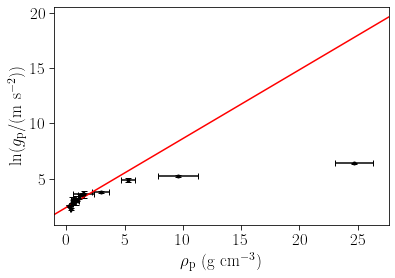

In [35]:
iteri = 0
for indX in range(plotData.shape[1]):
    nameX = labels[indX]
    for indY_temp in range(plotData[:,(indX+1):,:].shape[1]):
        indY = indY_temp+(indX+1)
        nameY = labels[indY]
        
        x_data = plotData[:,indX,0]
        y_data = plotData[:,indY,0]
        x_sigma = np.abs(plotData[:,indX,1])
        y_sigma = np.abs(plotData[:,indY,1])

        r = pearsonr(x_data,y_data)
        if r[1]<0.05:
            iteri +=1
            if iteri in [0]:
                continue
            
            print(iteri)
            print(r)
            
            polyVars = np.polyfit(x_data, y_data, 1)
            
            params = []
            param_errs = []
            for i in tqdm(range(10001)):
                if i==0:
                    x_temp=x_data
                    y_temp=y_data
                    sx_temp=x_sigma
                    sy_temp=y_sigma
                else:
                    x_temp=np.random.normal(x_data, x_sigma)
                    y_temp=np.random.normal(y_data, y_sigma)
                    sx_temp=x_sigma
                    sy_temp=y_sigma
                data = scipy.odr.RealData(x=x_temp, y=y_temp, sx=sx_temp, sy=sy_temp)
                def swapped(a,b):
                    return func(b,*a)
                func      = linear
                model = scipy.odr.Model(swapped)

                p_guess   = tuple(polyVars[::-1])
                fitted = scipy.odr.ODR(data, model, beta0=p_guess, maxit=50, job=0)

                output = fitted.run()
                p   = output.beta
                cov = output.cov_beta
                quasi_chisq = output.res_var
                uncertainty = output.sd_beta
                if quasi_chisq < 1.0 :
                    uncertainty = uncertainty/numpy.sqrt(quasi_chisq)
                if False: # debugging print statements
                    print("sd_beta",output.sd_beta)
                    print("cov_beta",output.cov_beta)
                    print("delta",output.delta)
                    print("epsilon",output.epsilon)
                    print("res_var",output.res_var)
                    print("rel_error",output.rel_error)

                if i==0:
                    print("**** ODR has finished with: " + output.stopreason[0])
                    for j in range(len(p)) :
                        print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
                               "          Guessed: {3:<10.5g}").
                                format(j,p[j],uncertainty[j],p_guess[j]))

                params.append(p)
                param_errs.append(uncertainty)
            params = np.array(params)
            param_errs = np.array(param_errs)

            print("**** MC uncertainty finding has finished")
            for j in range(len(p)) :
                print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
                       "          Guessed: {3:<10.5g}").
                        format(j,np.median(params[1:,j]),np.std(params[1:,j]),p_guess[j]))
                bias             = np.median(params[1:,j])/params[0,j]-1
                sorted_p_i = numpy.sort(params)[:,j]
                # Note: Am using Gaussian approximation for median uncertainty
                bias_uncertainty = (abs((param_errs[0,j]/params[0,j]))
                                        / numpy.sqrt(params.shape[0]-1-1)
                                        * numpy.sqrt(numpy.pi/2))
                print("   p[{0}] Bias : {1:<+9.4g} +/- {2:<9.4g} ({3:7.2f} SD)"
                      .format(j, bias, bias_uncertainty, bias/bias_uncertainty) )

            plt.errorbar(x_data, y_data, xerr=x_sigma, yerr=y_sigma, fmt='.', capsize=3, color='black')
            xlim = plt.gca().get_xlim()

            polyVars = [*np.median(params[1:], axis=0)[::-1]]
            x_smooth = np.linspace(xlim[0], xlim[1], 100)
            y_smooth = np.polyval(polyVars, x_smooth)
            plt.plot(x_smooth, y_smooth, '-', c='r')

            plt.xlim(*xlim)
            plt.ylabel(nameY)
            plt.xlabel(nameX)
            plt.show()

(-0.4680079786474447, 0.05815066043653649)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    0.41541 +/-   0.041631          Guessed: 0.17761   
   p[1] =   -0.19546 +/-   0.069978          Guessed: -0.023675 


100%|██████████| 10001/10001 [00:10<00:00, 937.40it/s]


**** MC uncertainty finding has finished
   p[0] =    0.41226 +/-   0.047733          Guessed: 0.17761   
   p[0] Bias : -0.007588 +/- 0.001256  (  -6.04 SD)
   p[1] =   -0.19187 +/-    0.10315          Guessed: -0.023675 
   p[1] Bias : -0.01838  +/- 0.004487  (  -4.10 SD)


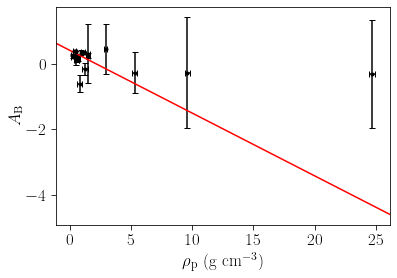

In [38]:
indX = 7
indY = -5

nameX = labels[indY]
nameY = labels[indX]

x_data = plotData[:,indY,0]
y_data = plotData[:,indX,0]

x_sigma = plotData[:,indX,1]
y_sigma = plotData[:,indY,1]

r = pearsonr(x_data,y_data)
print(r)

polyVars = np.polyfit(x_data, y_data, 1)
            
params = []
param_errs = []
for i in tqdm(range(10001)):
    if i==0:
        x_temp=x_data
        y_temp=y_data
        sx_temp=x_sigma
        sy_temp=y_sigma
    else:
        x_temp=np.random.normal(x_data, x_sigma)
        y_temp=np.random.normal(y_data, y_sigma)
        sx_temp=x_sigma
        sy_temp=y_sigma
    data = scipy.odr.RealData(x=x_temp, y=y_temp, sx=sx_temp, sy=sy_temp)
    def swapped(a,b):
        return func(b,*a)
    func      = linear
    model = scipy.odr.Model(swapped)

    p_guess   = tuple(polyVars[::-1])
    fitted = scipy.odr.ODR(data, model, beta0=p_guess, maxit=50, job=0)

    output = fitted.run()
    p   = output.beta
    cov = output.cov_beta
    quasi_chisq = output.res_var
    uncertainty = output.sd_beta
    if quasi_chisq < 1.0 :
        uncertainty = uncertainty/numpy.sqrt(quasi_chisq)
    if False: # debugging print statements
        print("sd_beta",output.sd_beta)
        print("cov_beta",output.cov_beta)
        print("delta",output.delta)
        print("epsilon",output.epsilon)
        print("res_var",output.res_var)
        print("rel_error",output.rel_error)

    if i==0:
        print("**** ODR has finished with: " + output.stopreason[0])
        for j in range(len(p)) :
            print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
                   "          Guessed: {3:<10.5g}").
                    format(j,p[j],uncertainty[j],p_guess[j]))

    params.append(p)
    param_errs.append(uncertainty)
params = np.array(params)
param_errs = np.array(param_errs)

print("**** MC uncertainty finding has finished")
for j in range(len(p)) :
    print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
           "          Guessed: {3:<10.5g}").
            format(j,np.median(params[1:,j]),np.std(params[1:,j]),p_guess[j]))
    bias             = np.median(params[1:,j])/params[0,j]-1
    sorted_p_i = numpy.sort(params)[:,j]
    # Note: Am using Gaussian approximation for median uncertainty
    bias_uncertainty = (abs((param_errs[0,j]/params[0,j]))
                            / numpy.sqrt(params.shape[0]-1-1)
                            * numpy.sqrt(numpy.pi/2))
    print("   p[{0}] Bias : {1:<+9.4g} +/- {2:<9.4g} ({3:7.2f} SD)"
          .format(j, bias, bias_uncertainty, bias/bias_uncertainty) )

plt.errorbar(x_data, y_data, xerr=x_sigma, yerr=y_sigma, fmt='.', capsize=3, color='black')
xlim = plt.gca().get_xlim()

polyVars = [*np.median(params[1:], axis=0)[::-1]]
x_smooth = np.linspace(xlim[0], xlim[1], 100)
y_smooth = np.polyval(polyVars, x_smooth)
plt.plot(x_smooth, y_smooth, '-', c='r')

plt.xlim(*xlim)
plt.ylabel(nameY)
plt.xlabel(nameX)
plt.show()

In [39]:
import emcee
def loglike(polyVars, x, y, yerr):
    #slope, inter = polyVars
    slope = polyVars
    return -0.5*np.sum((y-slope*x)**2/yerr**2)

8


100%|██████████| 100000/100000 [01:07<00:00, 1491.75it/s]


Mean acceptance fraction: 0.807
0.41429996368816446 0.011340753776224344
[0.41429996368816446, 0]


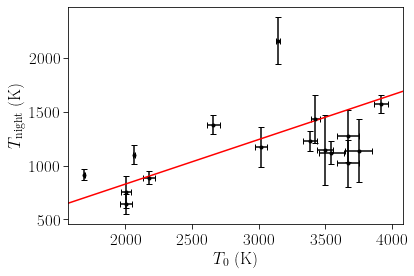

In [40]:
i = 0
for indX in range(plotData.shape[1]):
    nameX = labels[indX]
    for indY_temp in range(plotData[:,(indX+1):,:].shape[1]):
        indY = indY_temp+(indX+1)
        nameY = labels[indY]
        
        x = plotData[:,indX,0]
        y = plotData[:,indY,0]
        xerr = plotData[:,indX,1]
        yerr = plotData[:,indY,1]

        r = pearsonr(x,y)
        if r[1]<0.05:
            i +=1
            if i in [0]:#,1,2,3,4,5]:
                continue
            
            if i==8:
            
                print(i)
                
                x = x[planets!='KELT-9b']
                y = y[planets!='KELT-9b']
                xerr = xerr[planets!='KELT-9b']
                yerr = yerr[planets!='KELT-9b']

                plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')

                def line(polyVars, x, y):
                    #slope, inter = polyVars
                    slope = polyVars
                    return np.mean((y-slope*x)**2)
                
                xlim = plt.gca().get_xlim()
#                 polyVars = np.polyfit(x, y, 1)
#                 polyVars = scipy.optimize.minimize(line, [1,], args=(x,y), method='Nelder-Mead').x
                
                junkier = 1
                
                nwalkers = 20
                pos0 = np.random.normal(1,0.1,(nwalkers,1))
                sampler = emcee.EnsembleSampler(nwalkers, 1, loglike, args=(x,y,yerr), a = 2)
                pos2, prob, state = sampler.run_mcmc(pos0, 1e5, progress=True)
                print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

                print(np.median(sampler.flatchain), np.std(sampler.flatchain))
                
                polyVars = [np.median(sampler.flatchain),0]
                
#                 polyVars = [polyVars[0],0]
                x_smooth = np.linspace(xlim[0], xlim[1], 100)
                y_smooth = np.polyval(polyVars, x_smooth)
                plt.plot(x_smooth, y_smooth, '-', c='r')

                print(polyVars)

                plt.xlim(*xlim)
                plt.ylabel(nameY)
                plt.xlabel(nameX)
                plt.show()

8


  0%|          | 0/100001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    0.41655 +/-    0.02235          Guessed: 0.4       


100%|██████████| 100001/100001 [00:24<00:00, 4104.52it/s]


**** MC uncertainty finding has finished
   p[0] =    0.41658 +/-   0.010185          Guessed: 0.4       
   p[0] Bias : +8.491e-05 +/- 0.0002127 (   0.40 SD)


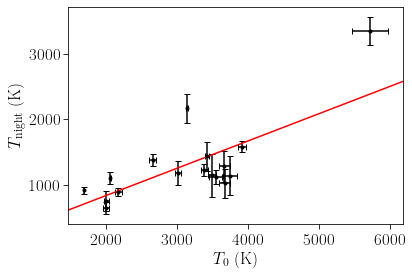

In [41]:
iteri = 0
for indX in range(plotData.shape[1]):
    nameX = labels[indX]
    for indY_temp in range(plotData[:,(indX+1):,:].shape[1]):
        indY = indY_temp+(indX+1)
        nameY = labels[indY]
        
        x = plotData[:,indX,0]
        y = plotData[:,indY,0]
        xerr = plotData[:,indX,1]
        yerr = plotData[:,indY,1]

        r = pearsonr(x,y)
        if r[1]<0.05:
            iteri +=1
            if iteri in [0]:#,1,2,3,4,5]:
                continue
            
            if iteri==8:
            
                print(iteri)

                x_data = x[planets!='KELT-9b']
                x_sigma = xerr[planets!='KELT-9b']
                y_data = y[planets!='KELT-9b']
                y_sigma = yerr[planets!='KELT-9b']
                
                params = []
                param_errs = []
                for i in tqdm(range(100001)):
                    if i==0:
                        x_temp=x_data
                        y_temp=y_data
                        sx_temp=x_sigma
                        sy_temp=y_sigma
                    else:
                        x_temp=np.random.normal(x_data, x_sigma)
                        y_temp=np.random.normal(y_data, y_sigma)
                        sx_temp=x_sigma
                        sy_temp=y_sigma
                    data = scipy.odr.RealData(x=x_temp, y=y_temp, sx=sx_temp, sy=sy_temp)
                    def swapped(a,b):
                        return func(b,*a)
                    func      = slope
                    model = scipy.odr.Model(swapped)

                    p_guess   = (0.4,)
                    fitted = scipy.odr.ODR(data, model, beta0=p_guess, maxit=50, job=0)

                    output = fitted.run()
                    p   = output.beta
                    cov = output.cov_beta
                    quasi_chisq = output.res_var
                    uncertainty = output.sd_beta
                    if quasi_chisq < 1.0 :
                        uncertainty = uncertainty/numpy.sqrt(quasi_chisq)
                    if False: # debugging print statements
                        print("sd_beta",output.sd_beta)
                        print("cov_beta",output.cov_beta)
                        print("delta",output.delta)
                        print("epsilon",output.epsilon)
                        print("res_var",output.res_var)
                        print("rel_error",output.rel_error)

                    if i==0:
                        print("**** ODR has finished with: " + output.stopreason[0])
                        for j in range(len(p)) :
                            print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
                                   "          Guessed: {3:<10.5g}").
                                    format(j,p[j],uncertainty[j],p_guess[j]))
                    
                    params.append(p)
                    param_errs.append(uncertainty)
                params = np.array(params)
                param_errs = np.array(param_errs)

                print("**** MC uncertainty finding has finished")
                for j in range(len(p)) :
                    print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
                           "          Guessed: {3:<10.5g}").
                            format(j,np.median(params[1:,j]),np.std(params[1:,j]),p_guess[j]))

                bias             = np.median(params[1:])/params[0][0]-1
                sorted_p_i = numpy.sort(params)[:,0]
                # Note: Am using Gaussian approximation for median uncertainty
                bias_uncertainty = (abs((param_errs[0][0]/params[0][0]))
                                        / numpy.sqrt(params.shape[0]-1-1)
                                        * numpy.sqrt(numpy.pi/2))
                print("   p[{0}] Bias : {1:<+9.4g} +/- {2:<9.4g} ({3:7.2f} SD)"
                      .format( 0, bias, bias_uncertainty, bias/bias_uncertainty) )

                plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')
                xlim = plt.gca().get_xlim()

                polyVars = [np.median(params[1:,0]),0]
                x_smooth = np.linspace(xlim[0], xlim[1], 100)
                y_smooth = np.polyval(polyVars, x_smooth)
                plt.plot(x_smooth, y_smooth, '-', c='r')

                plt.xlim(*xlim)
                plt.ylabel(nameY)
                plt.xlabel(nameX)
                plt.show()

In [42]:
# OG MCMC: 0.4185670741189461 +/- 0.0113442685793971

7


100%|██████████| 100000/100000 [01:08<00:00, 1454.57it/s]


Mean acceptance fraction: 0.807
0.8352953541747609 0.010026197521234813
[0.8352953541747609, 0]


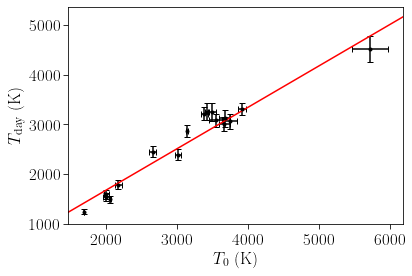

In [43]:
i = 0
for indX in range(plotData.shape[1]):
    nameX = labels[indX]
    for indY_temp in range(plotData[:,(indX+1):,:].shape[1]):
        indY = indY_temp+(indX+1)
        nameY = labels[indY]
        
        x = plotData[:,indX,0]
        y = plotData[:,indY,0]
        xerr = plotData[:,indX,1]
        yerr = plotData[:,indY,1]

        r = pearsonr(x,y)
        if r[1]<0.05:
            i +=1
            if i in [0]:#,1,2,3,4,5]:
                continue
            
            if i==7:
            
                print(i)

                plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')
                
                x = x[planets!='KELT-9b']
                y = y[planets!='KELT-9b']
                xerr = xerr[planets!='KELT-9b']
                yerr = yerr[planets!='KELT-9b']
                
                def line(polyVars, x, y):
                    #slope, inter = polyVars
                    slope = polyVars
                    return np.mean((y-slope*x)**2)
                
                xlim = plt.gca().get_xlim()
#                 polyVars = np.polyfit(x, y, 1)
#                 polyVars = scipy.optimize.minimize(line, [1,], args=(x,y), method='Nelder-Mead').x
                
                junkier = 1
                
                nwalkers = 20
                pos0 = np.random.normal(1,0.1,(nwalkers,1))
                sampler = emcee.EnsembleSampler(nwalkers, 1, loglike, args=(x,y,yerr), a = 2)
                pos2, prob, state = sampler.run_mcmc(pos0, 1e5, progress=True)
                print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

                print(np.median(sampler.flatchain), np.std(sampler.flatchain))
                
                polyVars = [np.median(sampler.flatchain),0]
                
#                 polyVars = [polyVars[0],0]
                x_smooth = np.linspace(xlim[0], xlim[1], 100)
                y_smooth = np.polyval(polyVars, x_smooth)
                plt.plot(x_smooth, y_smooth, '-', c='r')

                print(polyVars)

                plt.xlim(*xlim)
                plt.ylabel(nameY)
                plt.xlabel(nameX)
                plt.show()

7


  0%|          | 0/100001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    0.83507 +/-   0.019028          Guessed: 0.8       


100%|██████████| 100001/100001 [00:24<00:00, 4118.91it/s]


**** MC uncertainty finding has finished
   p[0] =    0.83507 +/-   0.010473          Guessed: 0.8       
   p[0] Bias : +2.019e-06 +/- 9.031e-05 (   0.02 SD)


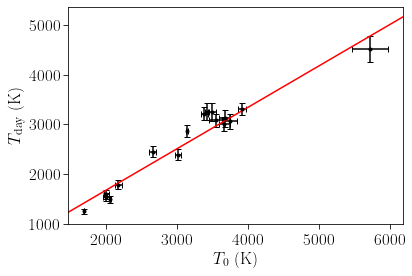

In [44]:
iteri = 0
for indX in range(plotData.shape[1]):
    nameX = labels[indX]
    for indY_temp in range(plotData[:,(indX+1):,:].shape[1]):
        indY = indY_temp+(indX+1)
        nameY = labels[indY]
        
        x = plotData[:,indX,0]
        y = plotData[:,indY,0]
        xerr = plotData[:,indX,1]
        yerr = plotData[:,indY,1]

        r = pearsonr(x,y)
        if r[1]<0.05:
            iteri +=1
            if iteri in [0]:#,1,2,3,4,5]:
                continue
            
            if iteri==7:
            
                print(iteri)

                x_data = x[planets!='KELT-9b']
                x_sigma = xerr[planets!='KELT-9b']
                y_data = y[planets!='KELT-9b']
                y_sigma = yerr[planets!='KELT-9b']
                
                params = []
                param_errs = []
                for i in tqdm(range(100001)):
                    if i==0:
                        x_temp=x_data
                        y_temp=y_data
                        sx_temp=x_sigma
                        sy_temp=y_sigma
                    else:
                        x_temp=np.random.normal(x_data, x_sigma)
                        y_temp=np.random.normal(y_data, y_sigma)
                        sx_temp=x_sigma
                        sy_temp=y_sigma
                    data = scipy.odr.RealData(x=x_temp, y=y_temp, sx=sx_temp, sy=sy_temp)
                    def swapped(a,b):
                        return func(b,*a)
                    func      = slope
                    model = scipy.odr.Model(swapped)

                    p_guess   = (0.8,)
                    fitted = scipy.odr.ODR(data, model, beta0=p_guess, maxit=50, job=0)

                    output = fitted.run()
                    p   = output.beta
                    cov = output.cov_beta
                    quasi_chisq = output.res_var
                    uncertainty = output.sd_beta
                    if quasi_chisq < 1.0 :
                        uncertainty = uncertainty/numpy.sqrt(quasi_chisq)
                    if False: # debugging print statements
                        print("sd_beta",output.sd_beta)
                        print("cov_beta",output.cov_beta)
                        print("delta",output.delta)
                        print("epsilon",output.epsilon)
                        print("res_var",output.res_var)
                        print("rel_error",output.rel_error)

                    if i==0:
                        print("**** ODR has finished with: " + output.stopreason[0])
                        for j in range(len(p)) :
                            print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
                                   "          Guessed: {3:<10.5g}").
                                    format(j,p[j],uncertainty[j],p_guess[j]))
                    
                    params.append(p)
                    param_errs.append(uncertainty)
                params = np.array(params)
                param_errs = np.array(param_errs)

                print("**** MC uncertainty finding has finished")
                for j in range(len(p)) :
                    print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
                           "          Guessed: {3:<10.5g}").
                            format(j,np.median(params[1:,j]),np.std(params[1:,j]),p_guess[j]))

                bias             = np.median(params[1:])/params[0][0]-1
                sorted_p_i = numpy.sort(params)[:,0]
                # Note: Am using Gaussian approximation for median uncertainty
                bias_uncertainty = (abs((param_errs[0][0]/params[0][0]))
                                        / numpy.sqrt(params.shape[0]-1-1)
                                        * numpy.sqrt(numpy.pi/2))
                print("   p[{0}] Bias : {1:<+9.4g} +/- {2:<9.4g} ({3:7.2f} SD)"
                      .format( 0, bias, bias_uncertainty, bias/bias_uncertainty) )

                plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')
                xlim = plt.gca().get_xlim()

                polyVars = [np.median(params[1:,0]),0]
                x_smooth = np.linspace(xlim[0], xlim[1], 100)
                y_smooth = np.polyval(polyVars, x_smooth)
                plt.plot(x_smooth, y_smooth, '-', c='r')

                plt.xlim(*xlim)
                plt.ylabel(nameY)
                plt.xlabel(nameX)
                plt.show()

In [45]:
# OG MCMC: 0.8353049854841166 +/- 0.010060517041312684

22


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    0.92537 +/-   0.027611          Guessed: 0.9       
   p[1] = -0.0069736 +/-  0.0014756          Guessed: -0.004    


100%|██████████| 10001/10001 [00:05<00:00, 1958.06it/s]


**** MC uncertainty finding has finished
   p[0] =    0.92546 +/-  0.0064043          Guessed: 0.9       
   p[0] Bias : +0.0001012 +/- 0.000374  (   0.27 SD)
   p[1] =  -0.006975 +/- 0.00034799          Guessed: -0.004    
   p[1] Bias : +0.0001967 +/- 0.002652  (   0.07 SD)


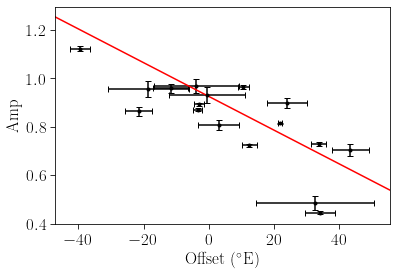

In [57]:
iteri = 0
for indX in range(plotData.shape[1]):
    nameX = labels[indX]
    for indY_temp in range(plotData[:,(indX+1):,:].shape[1]):
        indY = indY_temp+(indX+1)
        nameY = labels[indY]
        
        x = plotData[:,indX,0]
        y = plotData[:,indY,0]
        xerr = plotData[:,indX,1]
        yerr = plotData[:,indY,1]

        r = pearsonr(x,y)
        if r[1]<0.05:
            iteri +=1
            if iteri in [0]:#,1,2,3,4,5]:
                continue
            
            if iteri==22:
            
                print(iteri)

                x_data = x
                x_sigma = xerr
                y_data = y
                y_sigma = yerr
                
                params = []
                param_errs = []
                for i in tqdm(range(10001)):
                    if i==0:
                        x_temp=x_data
                        y_temp=y_data
                        sx_temp=x_sigma
                        sy_temp=y_sigma
                    else:
                        x_temp=np.random.normal(x_data, x_sigma)
                        y_temp=np.random.normal(y_data, y_sigma)
                        sx_temp=x_sigma
                        sy_temp=y_sigma
                    data = scipy.odr.RealData(x=x_temp, y=y_temp, sx=sx_temp, sy=sy_temp)
                    def swapped(a,b):
                        return func(b,*a)
                    func      = linear
                    model = scipy.odr.Model(swapped)

                    p_guess   = (0.9, -0.004)
                    fitted = scipy.odr.ODR(data, model, beta0=p_guess, maxit=50, job=0)

                    output = fitted.run()
                    p   = output.beta
                    cov = output.cov_beta
                    quasi_chisq = output.res_var
                    uncertainty = output.sd_beta
                    if quasi_chisq < 1.0 :
                        uncertainty = uncertainty/numpy.sqrt(quasi_chisq)
                    if False: # debugging print statements
                        print("sd_beta",output.sd_beta)
                        print("cov_beta",output.cov_beta)
                        print("delta",output.delta)
                        print("epsilon",output.epsilon)
                        print("res_var",output.res_var)
                        print("rel_error",output.rel_error)

                    if i==0:
                        print("**** ODR has finished with: " + output.stopreason[0])
                        for j in range(len(p)) :
                            print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
                                   "          Guessed: {3:<10.5g}").
                                    format(j,p[j],uncertainty[j],p_guess[j]))
                    
                    params.append(p)
                    param_errs.append(uncertainty)
                params = np.array(params)
                param_errs = np.array(param_errs)

                print("**** MC uncertainty finding has finished")
                for j in range(len(p)) :
                    print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
                           "          Guessed: {3:<10.5g}").
                            format(j,np.median(params[1:,j]),np.std(params[1:,j]),p_guess[j]))
                    bias             = np.median(params[1:,j])/params[0,j]-1
                    sorted_p_i = numpy.sort(params)[:,j]
                    # Note: Am using Gaussian approximation for median uncertainty
                    bias_uncertainty = (abs((param_errs[0,j]/params[0,j]))
                                            / numpy.sqrt(params.shape[0]-1-1)
                                            * numpy.sqrt(numpy.pi/2))
                    print("   p[{0}] Bias : {1:<+9.4g} +/- {2:<9.4g} ({3:7.2f} SD)"
                          .format(j, bias, bias_uncertainty, bias/bias_uncertainty) )

                plt.errorbar(x_data, y_data, xerr=x_sigma, yerr=y_sigma, fmt='.', capsize=3, color='black')
                xlim = plt.gca().get_xlim()

                polyVars = [*np.median(params[1:], axis=0)[::-1]]
                x_smooth = np.linspace(xlim[0], xlim[1], 100)
                y_smooth = np.polyval(polyVars, x_smooth)
                plt.plot(x_smooth, y_smooth, '-', c='r')

                plt.xlim(*xlim)
                plt.ylabel(nameY)
                plt.xlabel(nameX)
                plt.show()

22
(-0.391881854619355, 0.11978232205022274)


  0%|          | 0/10001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =     1.2791 +/-    0.30553          Guessed: 0.9       
   p[1] =  -0.025381 +/-   0.017325          Guessed: -0.004    


100%|██████████| 10001/10001 [00:11<00:00, 901.05it/s]


**** MC uncertainty finding has finished
   p[0] =     1.2782 +/-    0.09311          Guessed: 0.9       
   p[0] Bias : -0.0007111 +/- 0.002994  (  -0.24 SD)
   p[1] =  -0.025306 +/-   0.005334          Guessed: -0.004    
   p[1] Bias : -0.002958 +/- 0.008556  (  -0.35 SD)


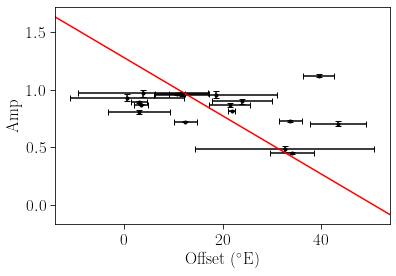

In [60]:
iteri = 0
for indX in range(plotData.shape[1]):
    nameX = labels[indX]
    for indY_temp in range(plotData[:,(indX+1):,:].shape[1]):
        indY = indY_temp+(indX+1)
        nameY = labels[indY]
        
        x = plotData[:,indX,0]
        y = plotData[:,indY,0]
        xerr = plotData[:,indX,1]
        yerr = plotData[:,indY,1]

        r = pearsonr(x,y)
        if r[1]<0.05:
            iteri +=1
            if iteri in [0]:#,1,2,3,4,5]:
                continue
            
            if iteri==22:
            
                print(iteri)

                x_data = np.abs(x)
                x_sigma = xerr
                y_data = y
                y_sigma = yerr
                
                r = pearsonr(x_data,y_data)
                print(r)
                
                params = []
                param_errs = []
                for i in tqdm(range(10001)):
                    if i==0:
                        x_temp=x_data
                        y_temp=y_data
                        sx_temp=x_sigma
                        sy_temp=y_sigma
                    else:
                        x_temp=np.random.normal(x_data, x_sigma)
                        y_temp=np.random.normal(y_data, y_sigma)
                        sx_temp=x_sigma
                        sy_temp=y_sigma
                    data = scipy.odr.RealData(x=x_temp, y=y_temp, sx=sx_temp, sy=sy_temp)
                    def swapped(a,b):
                        return func(b,*a)
                    func      = linear
                    model = scipy.odr.Model(swapped)

                    p_guess   = (0.9, -0.004)
                    fitted = scipy.odr.ODR(data, model, beta0=p_guess, maxit=50, job=0)

                    output = fitted.run()
                    p   = output.beta
                    cov = output.cov_beta
                    quasi_chisq = output.res_var
                    uncertainty = output.sd_beta
                    if quasi_chisq < 1.0 :
                        uncertainty = uncertainty/numpy.sqrt(quasi_chisq)
                    if False: # debugging print statements
                        print("sd_beta",output.sd_beta)
                        print("cov_beta",output.cov_beta)
                        print("delta",output.delta)
                        print("epsilon",output.epsilon)
                        print("res_var",output.res_var)
                        print("rel_error",output.rel_error)

                    if i==0:
                        print("**** ODR has finished with: " + output.stopreason[0])
                        for j in range(len(p)) :
                            print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
                                   "          Guessed: {3:<10.5g}").
                                    format(j,p[j],uncertainty[j],p_guess[j]))
                    
                    params.append(p)
                    param_errs.append(uncertainty)
                params = np.array(params)
                param_errs = np.array(param_errs)

                print("**** MC uncertainty finding has finished")
                for j in range(len(p)) :
                    print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
                           "          Guessed: {3:<10.5g}").
                            format(j,np.median(params[1:,j]),np.std(params[1:,j]),p_guess[j]))
                    bias             = np.median(params[1:,j])/params[0,j]-1
                    sorted_p_i = numpy.sort(params)[:,j]
                    # Note: Am using Gaussian approximation for median uncertainty
                    bias_uncertainty = (abs((param_errs[0,j]/params[0,j]))
                                            / numpy.sqrt(params.shape[0]-1-1)
                                            * numpy.sqrt(numpy.pi/2))
                    print("   p[{0}] Bias : {1:<+9.4g} +/- {2:<9.4g} ({3:7.2f} SD)"
                          .format(j, bias, bias_uncertainty, bias/bias_uncertainty) )

                plt.errorbar(x_data, y_data, xerr=x_sigma, yerr=y_sigma, fmt='.', capsize=3, color='black')
                xlim = plt.gca().get_xlim()

                polyVars = [*np.median(params[1:], axis=0)[::-1]]
                x_smooth = np.linspace(xlim[0], xlim[1], 100)
                y_smooth = np.polyval(polyVars, x_smooth)
                plt.plot(x_smooth, y_smooth, '-', c='r')

                plt.xlim(*xlim)
                plt.ylabel(nameY)
                plt.xlabel(nameX)
                plt.show()

In [34]:
print('&', ' & '.join(labels)+' \\\\')
for indX in range(plotData.shape[1]):
    nameX = labels[indX]
    string = nameX+' & '
    for indY_temp in range(plotData.shape[1]):
        indY = indY_temp
        nameY = labels[indY]
        
        x = plotData[:,indX,0]
        y = plotData[:,indY,0]
        xerr = plotData[:,indX,1]
        yerr = plotData[:,indY,1]

        r = pearsonr(x,y)
        
        string += format(np.round(r[0], 2), '0.2f')+' & '
    string = string[:-3]+' \\\\'
    print(string)

& $T_{\rm *}~\rm (K)$ & $T_{\rm 0}~\rm (K)$ & $T_{\rm day}~\rm (K)$ & $T_{\rm night}~\rm (K)$ & $A$ & $\rm Offset~\rm (^{\circ}E)$ & $\epsilon$ & $A_{\rm B}$ & $R_{\rm p}~(R_{\rm Jup})$ & $M_{\rm p}~\rm (M_{\rm Jup})$ & $\ln(M_{\rm p}/M_{\rm Jup})$ & $\rho_{\rm p}~\rm (g~cm^{-3})$ & $\ln(g_{\rm p} / ({\rm m~s^{-2}}))$ & $P~\rm (days)$ & $\rm [Fe/H]_{\rm *}$ \\
$T_{\rm *}~\rm (K)$ & 1.00 & 0.90 & 0.84 & 0.86 & -0.49 & 0.29 & 0.21 & -0.23 & 0.70 & 0.11 & 0.26 & 0.00 & 0.00 & 0.06 & -0.15 \\
$T_{\rm 0}~\rm (K)$ & 0.90 & 1.00 & 0.97 & 0.77 & -0.24 & 0.10 & -0.09 & -0.25 & 0.70 & 0.11 & 0.24 & 0.03 & -0.01 & -0.33 & 0.07 \\
$T_{\rm day}~\rm (K)$ & 0.84 & 0.97 & 1.00 & 0.73 & -0.19 & 0.02 & -0.16 & -0.44 & 0.61 & 0.25 & 0.39 & 0.17 & 0.15 & -0.38 & 0.06 \\
$T_{\rm night}~\rm (K)$ & 0.86 & 0.77 & 0.73 & 1.00 & -0.77 & 0.45 & 0.50 & -0.43 & 0.56 & 0.07 & 0.16 & -0.01 & -0.04 & 0.08 & -0.05 \\
$A$ & -0.49 & -0.24 & -0.19 & -0.77 & 1.00 & -0.73 & -0.92 & 0.34 & -0.29 & 0.07 & 0.11 & 0.11 & 0.19 

In [35]:
''.join(['c|' for label in labels])

'c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|'

In [36]:
junk = '''979±58 979±58 1015±86 792±64 1098±201 1267±111 986±233 1507±285 1128±108 815±463 1528±108 1256±386 1776±165'''.split(' ')
junk = np.array([junk[i].split('±') for i in range(len(junk))]).astype(float)

100%|██████████| 10000/10000 [00:07<00:00, 1334.19it/s]


Mean acceptance fraction: 0.806
0.44029271279153265 0.01911482945735141
[0.44029271279153265, 0]


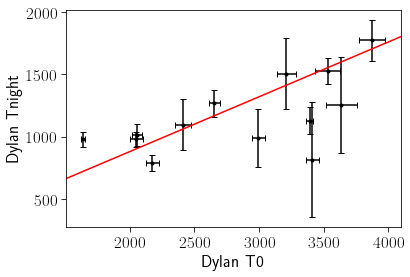

In [37]:
x = [1636,2051,2053,2175,2411, 2654,2995, 3211,3391,3412,3530,3636,3874]
y = junk[:,0]
xerr = [14,53,38,47,59,43,52,75,29,49,99,121,104]
yerr = junk[:,1]

r = pearsonr(x,y)

plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')

def line(polyVars, x, y):
    #slope, inter = polyVars
    slope = polyVars
    return np.mean((y-slope*x)**2)

xlim = plt.gca().get_xlim()
# polyVars = np.polyfit(x, y, 1)
# polyVars = scipy.optimize.minimize(line, [1,], args=(x,y), method='Nelder-Mead').x

junkier = 1

nwalkers = 20
pos0 = np.random.normal(1,0.1,(nwalkers,1))
sampler = emcee.EnsembleSampler(nwalkers, 1, loglike, args=(x,y,yerr), a = 2)
pos2, prob, state = sampler.run_mcmc(pos0, 1e4, progress=True)
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

print(np.median(sampler.flatchain), np.std(sampler.flatchain))

polyVars = [np.median(sampler.flatchain),0]

# polyVars = [polyVars[0],0]
x_smooth = np.linspace(xlim[0], xlim[1], 100)
y_smooth = np.polyval(polyVars, x_smooth)
plt.plot(x_smooth, y_smooth, '-', c='r')

print(polyVars)

plt.xlim(*xlim)
plt.ylabel('Dylan Tnight')
plt.xlabel('Dylan T0')
plt.show()

  0%|          | 0/100001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =    0.44088 +/-   0.023485          Guessed: 0.8       


100%|██████████| 100001/100001 [00:24<00:00, 4057.55it/s]


**** MC uncertainty finding has finished
   p[0] =    0.44085 +/-    0.01195          Guessed: 0.8       
   p[0] Bias : -6.628e-05 +/- 0.0006676 (  -0.10 SD)


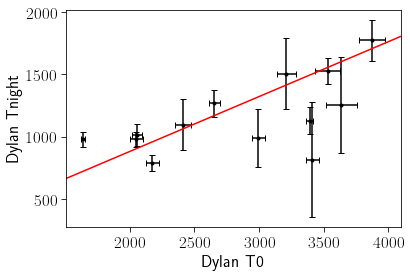

In [38]:
params = []
param_errs = []
for i in tqdm(range(100001)):
    if i==0:
        x_temp=x
        y_temp=y
        sx_temp=xerr
        sy_temp=yerr
    else:
        x_temp=np.random.normal(x, xerr)
        y_temp=np.random.normal(y, yerr)
        sx_temp=xerr
        sy_temp=yerr
    data = scipy.odr.RealData(x=x_temp, y=y_temp, sx=sx_temp, sy=sy_temp)
    def swapped(a,b):
        return func(b,*a)
    func      = slope
    model = scipy.odr.Model(swapped)

    p_guess   = (0.8,)
    fitted = scipy.odr.ODR(data, model, beta0=p_guess, maxit=50, job=0)

    output = fitted.run()
    p   = output.beta
    cov = output.cov_beta
    quasi_chisq = output.res_var
    uncertainty = output.sd_beta
    if quasi_chisq < 1.0 :
        uncertainty = uncertainty/numpy.sqrt(quasi_chisq)
    if False: # debugging print statements
        print("sd_beta",output.sd_beta)
        print("cov_beta",output.cov_beta)
        print("delta",output.delta)
        print("epsilon",output.epsilon)
        print("res_var",output.res_var)
        print("rel_error",output.rel_error)

    if i==0:
        print("**** ODR has finished with: " + output.stopreason[0])
        for j in range(len(p)) :
            print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
                   "          Guessed: {3:<10.5g}").
                    format(j,p[j],uncertainty[j],p_guess[j]))

    params.append(p)
    param_errs.append(uncertainty)
params = np.array(params)
param_errs = np.array(param_errs)

print("**** MC uncertainty finding has finished")
for j in range(len(p)) :
    print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
           "          Guessed: {3:<10.5g}").
            format(j,np.median(params[1:,j]),np.std(params[1:,j]),p_guess[j]))

bias             = np.median(params[1:])/params[0][0]-1
sorted_p_i = numpy.sort(params)[:,0]
# Note: Am using Gaussian approximation for median uncertainty
bias_uncertainty = (abs((param_errs[0][0]/params[0][0]))
                        / numpy.sqrt(10000-1)
                        * numpy.sqrt(numpy.pi/2))
print("   p[{0}] Bias : {1:<+9.4g} +/- {2:<9.4g} ({3:7.2f} SD)"
      .format( 0, bias, bias_uncertainty, bias/bias_uncertainty) )

plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')
xlim = plt.gca().get_xlim()

polyVars = [np.median(params[1:,0]),0]
x_smooth = np.linspace(xlim[0], xlim[1], 100)
y_smooth = np.polyval(polyVars, x_smooth)
plt.plot(x_smooth, y_smooth, '-', c='r')

plt.xlim(*xlim)
plt.ylabel('Dylan Tnight')
plt.xlabel('Dylan T0')
plt.show()

In [39]:
# OG MCMC: 0.44030884007307486 +/- 0.02124792665766911

In [41]:
import emcee
import scipy
def loglike(polyVars, x, y, yerr):
    model = line(polyVars, x, y)
    return -0.5*np.sum((y-model)**2/yerr**2)

def neg_loglike(polyVars, x, y, yerr):
    return -loglike(polyVars, x, y, yerr)

def line(polyVars, x, y):
    if len(polyVars)==2:
        slope, inter = polyVars
    else:
        slope = polyVars
        inter = 0
    return slope*x+inter

100%|██████████| 100000/100000 [01:19<00:00, 1256.57it/s]


Mean acceptance fraction: 0.715
[ 0.08994227 -0.03251119] [0.02481058 0.03484498]
[ 0.08994227 -0.03251119]


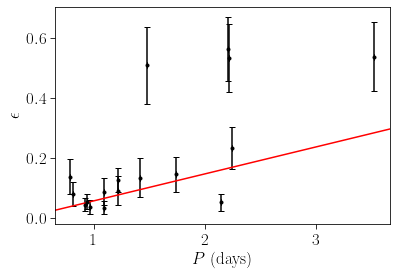

In [42]:
indX = -2
indY = -9

nameX = labels[indX]
nameY = labels[indY]

x = plotData[:,indX,0]
y = plotData[:,indY,0]
xerr = plotData[:,indX,1]
yerr = plotData[:,indY,1]

r = pearsonr(x,y)

plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')

# polyVars = np.polyfit(x, y, 1)
# polyVars = scipy.optimize.minimize(neg_loglike, [1,0], args=(x,y,yerr), method='Nelder-Mead').x

nwalkers = 20
ndim = 2
pos0 = np.random.normal(1,0.1,(nwalkers,ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike, args=(x,y,yerr), a = 2)
pos2, prob, state = sampler.run_mcmc(pos0, 1e5, progress=True)
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

print(np.median(sampler.flatchain, axis=0), np.std(sampler.flatchain, axis=0))

polyVars = np.median(sampler.flatchain, axis=0)
# polyVars = [np.median(sampler.flatchain),0]
# polyVars = [polyVars[0],0]
print(polyVars)

xlim = plt.gca().get_xlim()
x_smooth = np.linspace(xlim[0], xlim[1], 100)
y_smooth = np.polyval(polyVars, x_smooth)
plt.plot(x_smooth, y_smooth, '-', c='r')
plt.xlim(*xlim)
plt.ylabel(nameY)
plt.xlabel(nameX)
plt.show()

  0%|          | 0/100001 [00:00<?, ?it/s]

**** ODR has finished with: Sum of squares convergence
   p[0] =  -0.032603 +/-   0.052047          Guessed: -0.023826 
   p[1] =   0.090059 +/-   0.040631          Guessed: 0.079917  


100%|██████████| 100001/100001 [00:24<00:00, 4130.43it/s]


**** MC uncertainty finding has finished
   p[0] =  -0.032597 +/-   0.025388          Guessed: -0.023826 
   p[0] Bias : -0.0001874 +/- 0.006327  (  -0.03 SD)
   p[1] =   0.090077 +/-   0.019787          Guessed: 0.079917  
   p[1] Bias : +0.0002002 +/- 0.001788  (   0.11 SD)


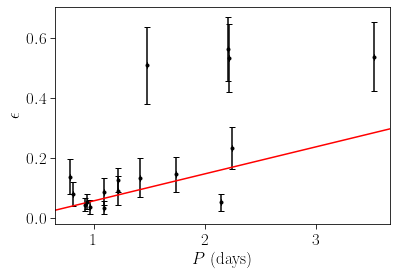

In [43]:
params = []
param_errs = []
for i in tqdm(range(100001)):
    if i==0:
        x_temp=x
        y_temp=y
        sx_temp=xerr
        sy_temp=yerr
    else:
        x_temp=np.random.normal(x, xerr)
        y_temp=np.random.normal(y, yerr)
        sx_temp=xerr
        sy_temp=yerr
    data = scipy.odr.RealData(x=x_temp, y=y_temp, sx=sx_temp, sy=sy_temp)
    def swapped(a,b):
        return func(b,*a)
    func      = linear
    model = scipy.odr.Model(swapped)

    p_guess   = (-0.02382594, 0.07991733)
    fitted = scipy.odr.ODR(data, model, beta0=p_guess, maxit=50, job=0)

    output = fitted.run()
    p   = output.beta
    cov = output.cov_beta
    quasi_chisq = output.res_var
    uncertainty = output.sd_beta
    if quasi_chisq < 1.0 :
        uncertainty = uncertainty/numpy.sqrt(quasi_chisq)
    if False: # debugging print statements
        print("sd_beta",output.sd_beta)
        print("cov_beta",output.cov_beta)
        print("delta",output.delta)
        print("epsilon",output.epsilon)
        print("res_var",output.res_var)
        print("rel_error",output.rel_error)

    if i==0:
        print("**** ODR has finished with: " + output.stopreason[0])
        for j in range(len(p)) :
            print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
                   "          Guessed: {3:<10.5g}").
                    format(j,p[j],uncertainty[j],p_guess[j]))

    params.append(p)
    param_errs.append(uncertainty)
params = np.array(params)
param_errs = np.array(param_errs)

print("**** MC uncertainty finding has finished")
for j in range(len(p)) :
    print(("   p[{0}] = {1:10.5g} +/- {2:10.5g}"+
           "          Guessed: {3:<10.5g}").
            format(j,np.median(params[1:,j]),np.std(params[1:,j]),p_guess[j]))
    bias             = np.median(params[1:,j])/params[0,j]-1
    sorted_p_i = numpy.sort(params)[:,j]
    # Note: Am using Gaussian approximation for median uncertainty
    bias_uncertainty = (abs((param_errs[0,j]/params[0,j]))
                            / numpy.sqrt(params.shape[0]-1-1)
                            * numpy.sqrt(numpy.pi/2))
    print("   p[{0}] Bias : {1:<+9.4g} +/- {2:<9.4g} ({3:7.2f} SD)"
          .format(j, bias, bias_uncertainty, bias/bias_uncertainty) )

plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')
xlim = plt.gca().get_xlim()

polyVars = [*np.median(params[1:], axis=0)[::-1]]
x_smooth = np.linspace(xlim[0], xlim[1], 100)
y_smooth = np.polyval(polyVars, x_smooth)
plt.plot(x_smooth, y_smooth, '-', c='r')

plt.xlim(*xlim)
plt.ylabel(nameY)
plt.xlabel(nameX)
plt.show()

In [44]:
# OG MCMC: 0.07991733 +/- 0.02294573; -0.02382594 +/- 0.02855624

100%|██████████| 10000/10000 [00:07<00:00, 1284.66it/s]


Mean acceptance fraction: 0.718
[-0.1531198   0.73154512] [0.02066966 0.03230791]
[-0.1531198   0.73154512]


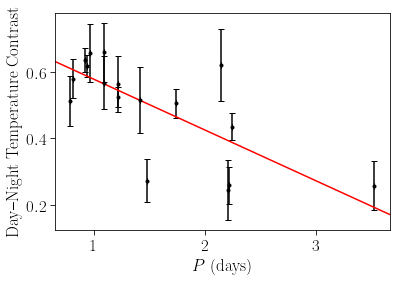

In [45]:
indX = -2

nameY = r'$\rm Day$--$\rm Night~Temperature~Contrast$'
nameX = labels[indX]

x = plotData[:,indX,0]
y = (1-plotData[:,3,0]/plotData[:,2,0])
xerr = plotData[:,indX,1]
yerr = np.sqrt((plotData[:,3,1]/plotData[:,2,0])**2+(plotData[:,3,0]/plotData[:,2,0]**2*plotData[:,2,1])**2)#plotData[:,indY,1]

r = pearsonr(x,y)

plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')

# polyVars = np.polyfit(x, y, 1)
polyVars = scipy.optimize.minimize(neg_loglike, [1,0], args=(x,y,yerr), method='Nelder-Mead').x

nwalkers = 20
ndim = 2
pos0 = polyVars*np.random.normal(1,0.1,(nwalkers,ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike, args=(x,y,yerr), a = 2)
pos2, prob, state = sampler.run_mcmc(pos0, 1e4, progress=True)
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

print(np.median(sampler.flatchain, axis=0), np.std(sampler.flatchain, axis=0))

polyVars = np.median(sampler.flatchain, axis=0)
# polyVars = [np.median(sampler.flatchain),0]
# polyVars = [polyVars[0],0]
print(polyVars)

xlim = plt.gca().get_xlim()
x_smooth = np.linspace(xlim[0], xlim[1], 100)
y_smooth = np.polyval(polyVars, x_smooth)
plt.plot(x_smooth, y_smooth, '-', c='r')
plt.xlim(*xlim)
plt.ylabel(nameY)
plt.xlabel(nameX)
plt.show()

100%|██████████| 10000/10000 [00:08<00:00, 1211.43it/s]


Mean acceptance fraction: 0.716
[2.70618499e-05 4.27356902e-01] [1.47089372e-05 4.87484058e-02]
[2.70618499e-05 4.27356902e-01]


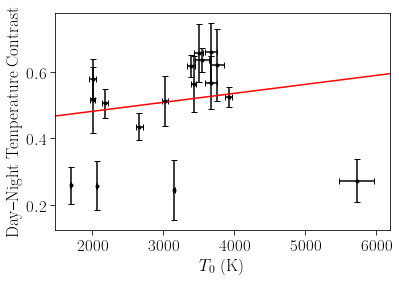

In [46]:
indX = 1

nameY = r'$\rm Day$--$\rm Night~Temperature~Contrast$'
nameX = labels[indX]

x = plotData[:,indX,0]
y = (1-plotData[:,3,0]/plotData[:,2,0])
xerr = plotData[:,indX,1]
yerr = np.sqrt((plotData[:,3,1]/plotData[:,2,0])**2+(plotData[:,3,0]/plotData[:,2,0]**2*plotData[:,2,1])**2)#plotData[:,indY,1]

r = pearsonr(x,y)

plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')

# polyVars = np.polyfit(x, y, 1)
polyVars = scipy.optimize.minimize(neg_loglike, [1,0], args=(x,y,yerr), method='Nelder-Mead').x

nwalkers = 20
ndim = 2
pos0 = polyVars*np.random.normal(1,0.1,(nwalkers,ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike, args=(x,y,yerr), a = 2)
pos2, prob, state = sampler.run_mcmc(pos0, 1e4, progress=True)
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

print(np.median(sampler.flatchain, axis=0), np.std(sampler.flatchain, axis=0))

polyVars = np.median(sampler.flatchain, axis=0)
# polyVars = [np.median(sampler.flatchain),0]
# polyVars = [polyVars[0],0]
print(polyVars)

xlim = plt.gca().get_xlim()
x_smooth = np.linspace(xlim[0], xlim[1], 100)
y_smooth = np.polyval(polyVars, x_smooth)
plt.plot(x_smooth, y_smooth, '-', c='r')
plt.xlim(*xlim)
plt.ylabel(nameY)
plt.xlabel(nameX)
plt.show()

In [ ]:
planets[y<0.4]

In [ ]:
plotData[:,-2,0][y<0.4]

In [ ]:
planets[y<0.45]